# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('../raw_data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]


data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(296, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [6]:
recommender.get_own_recommendations(296, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [7]:
recommender.get_similar_items_recommendation(296, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [8]:
recommender.get_similar_users_recommendation(296, N=5)

296
[1029743, 1106523, 5569230, 916122, 844179]


[1029743, 1106523, 5569230, 916122, 844179]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


##### Задание А)

In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [10]:
result_lvl_1['als_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))

In [11]:
result_lvl_1['own_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [12]:
result_lvl_1['sim_item_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))

In [14]:
result_lvl_1['sim_user_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

1
[6552318, 5564850, 1123106, 1135983, 1010578, 1027216, 997987, 1019247, 1135983, 949257, 12487154, 994223, 947412, 974336, 1115800, 938118, 935578, 5570513, 1072693, 979674, 9420183, 841584, 1104349, 6534078, 898121, 1027835, 847962, 6396492, 916990, 1093490, 1018339, 1052294, 8090560, 948640, 918046, 9420064, 993838, 967994, 1055168, 1030577, 1016785, 1093490, 928749, 974766, 894360, 8293439, 8090539, 832678, 1129982, 836085]
2
[875392, 1075368, 903529, 832661, 971474, 9802756, 1052294, 9419422, 830202, 879373, 8090956, 866548, 938165, 1091090, 1081533, 965772, 1031419, 1116297, 908217, 873324, 1036939, 928749, 1059080, 7146026, 973016, 1021416, 6463877, 1057168, 6772833, 9392700, 939681, 1065017, 1052294, 865233, 1042571, 1123045, 841287, 7160764, 1103808, 6391137, 1080867, 1057168, 823576, 948640, 873324, 1131634, 9487534, 820923, 1007571, 7024847]
4
[996298, 862535, 7166756, 948640, 1057168, 5566809, 7467039, 894360, 894360, 906202, 821741, 908314, 1122844, 1102003, 8357825, 7146

[1138292, 953539, 834993, 965889, 7169088, 938165, 955921, 1058404, 1103476, 879734, 1118946, 878442, 973016, 979505, 6919515, 5578856, 834435, 8019916, 963686, 916990, 7168058, 1118946, 836703, 892728, 1008288, 854133, 9677846, 953539, 1065259, 866548, 10285454, 894360, 835351, 12484491, 998519, 1069039, 5567702, 1087411, 953539, 9392953, 1098694, 6704207, 5569074, 938165, 937210, 834516, 1017739, 908314, 1059153, 1012701]
26
[1101932, 962967, 988697, 5591777, 911311, 12523928, 851188, 8203851, 918046, 865757, 879734, 832968, 6533681, 928932, 981165, 856818, 6391086, 822161, 902377, 977927, 7152319, 822115, 869868, 820486, 1139606, 1047349, 918638, 942045, 871514, 1114653, 924667, 1139569, 958067, 977927, 1055403, 10285454, 1096066, 8203606, 5569135, 1077600, 1037089, 1002787, 5574108, 902377, 972235, 1093413, 902377, 937110, 1114653, 936117]
27
[1074040, 1057168, 1058243, 8020166, 877428, 1097350, 9859017, 1036486, 12524245, 1074040, 1098284, 901067, 7443137, 1098284, 966619, 1031316

[879393, 967041, 834516, 886996, 979674, 1120190, 848684, 1010308, 9420067, 1053628, 820486, 948640, 7024847, 1093490, 878442, 897083, 5568758, 6632283, 896666, 1127732, 1033857, 7409622, 6979437, 1027835, 823099, 875392, 939860, 908514, 1075786, 894360, 1065979, 6632283, 1128395, 1024319, 823576, 1031419, 963686, 959830, 954146, 1034956, 5570513, 6533368, 1059347, 896666, 7167903, 848684, 6979518, 879734, 911974, 957080]
47
[904241, 949345, 849466, 1135578, 871722, 907099, 931124, 5568732, 989409, 925350, 908514, 9831557, 974265, 949257, 820486, 9677466, 9653535, 1133051, 939860, 1138596, 8119231, 1008288, 1138596, 1021416, 1046037, 1089568, 1025650, 1079528, 900379, 7467039, 906900, 1134006, 1069506, 879922, 1117219, 948225, 1109778, 8090956, 8090508, 1018818, 13072793, 5566472, 823099, 970160, 928932, 6533236, 820486, 12427353, 1023160, 847962]
49
[857348, 9392700, 6979579, 872146, 861184, 909497, 937210, 1030577, 894360, 949257, 985605, 5578856, 1086061, 1003524, 892573, 12949590, 

[899115, 1121694, 938118, 894360, 842698, 1024489, 6463710, 9396822, 852360, 1018339, 870804, 994223, 922561, 6979437, 935578, 899115, 1044153, 855454, 914012, 834435, 957080, 1059347, 9677447, 866828, 959455, 7169090, 1027835, 1044500, 932949, 872066, 1078666, 1126045, 953539, 1010578, 841584, 887375, 949345, 878764, 5592757, 860703, 998519, 1057749, 1057168, 894360, 12263857, 1096563, 939789, 939789, 928749, 1041229]
71
[870804, 1132956, 7160764, 1103808, 896757, 865233, 1775642, 1098694, 953539, 1003487, 1118946, 1008288, 977559, 953539, 1087411, 1072917, 6704207, 1131634, 1086740, 1008288, 5568661, 892728, 1138292, 6533936, 973016, 825317, 926905, 965889, 965772, 10285454, 7168058, 1057168, 834993, 8119231, 1098284, 992650, 870804, 10149656, 8090653, 908504, 1097001, 1088683, 9859017, 1057749, 8090956, 1057168, 958023, 941515, 956125, 929410]
72
[1009361, 835499, 832492, 1117219, 989144, 872066, 1112405, 933102, 9392953, 864335, 1098892, 855202, 1090884, 1108055, 1058404, 1020623, 

[1112205, 902377, 1106117, 9420354, 962266, 9297574, 870515, 916990, 962967, 970160, 1112205, 12692328, 1128477, 9677152, 861184, 1126711, 6463900, 1134633, 9803433, 827332, 6979393, 1084036, 938300, 939789, 5572803, 820341, 894360, 1116050, 1011926, 867138, 9392953, 9527417, 9575582, 834516, 876626, 987786, 951727, 835351, 6391089, 1006922, 1092669, 5571781, 6391089, 1028422, 12731466, 970160, 870559, 5572803, 6391080, 1028422]
94
[1135044, 1134006, 870515, 1135578, 901253, 835351, 865026, 938300, 925350, 974766, 1080888, 970160, 1057168, 998741, 841236, 8293426, 1019247, 861184, 953191, 890490, 953539, 1117219, 7152319, 1088771, 1128477, 1036093, 953539, 929388, 5565784, 928749, 836085, 872826, 1080888, 6391089, 870559, 970160, 13039088, 1118120, 1116050, 1029272, 1129912, 962266, 962967, 8090560, 919126, 1112205, 1038692, 867138, 929388, 12692328]
95
[917427, 880895, 6443350, 9396822, 964221, 7410320, 6633167, 942045, 8090550, 9392700, 8090550, 1041229, 1082990, 932949, 1137771, 897

[5578856, 1043920, 1092937, 958067, 9245108, 992650, 1024065, 7146026, 9677454, 967041, 9553382, 1010308, 879734, 953539, 1006922, 908504, 1059153, 834993, 9677846, 820923, 7169088, 886996, 1136657, 1031419, 5590965, 1057168, 1061228, 1054402, 1012801, 890423, 1134296, 6979437, 12263841, 908314, 892728, 953180, 939681, 9487534, 955259, 984315, 1116297, 1092937, 5590965, 8090653, 1088414, 6704207, 1120190, 9487613, 6395907, 823576]
115
[871563, 1061228, 1131634, 12352249, 948640, 877310, 7024847, 1088979, 983753, 1112242, 7410217, 1032703, 966619, 880664, 1063739, 864893, 1117219, 9831557, 7169090, 5571178, 1117219, 841365, 9553048, 1048237, 1096573, 1053988, 830783, 848684, 12523928, 1087618, 830202, 1107760, 12808385, 7168057, 864893, 1084587, 942077, 9487534, 1138596, 847434, 1097350, 1036495, 823031, 965772, 917033, 1117219, 6979753, 7168286, 9419422, 12523928]
116
[1074040, 1014732, 906917, 1114653, 997025, 1121694, 830740, 1019637, 1124971, 1114653, 1014388, 1000925, 997025, 97779

[834516, 996009, 949345, 932949, 5568732, 1036699, 977927, 935578, 8119103, 6704415, 906900, 939789, 897270, 879922, 8015407, 1096228, 1126045, 1123106, 1138596, 906900, 841584, 935578, 922561, 1024489, 13007065, 8090549, 873044, 1079528, 1044153, 831587, 916990, 7169088, 938118, 1104349, 5575861, 1117690, 852235, 1016785, 928749, 5568072, 832678, 1121694, 927277, 9859017, 830686, 949257, 891415, 872066, 948640, 1091342]
136
[1057749, 1132956, 879922, 839656, 958067, 917393, 1057168, 820612, 977559, 1086740, 9553335, 1048299, 871514, 5568758, 1095227, 7082640, 1057168, 6391137, 835618, 1056212, 841365, 7024847, 879734, 847962, 9859017, 1080867, 8090612, 903529, 6534552, 6704415, 837969, 9803433, 820486, 1095227, 937110, 1021715, 9446069, 1138292, 8090550, 951176, 879699, 12808385, 1055403, 1069039, 1094744, 942045, 820486, 937110, 1065979, 1072917]
137
[1092588, 849297, 879393, 5592757, 894360, 1053329, 825541, 853448, 7142552, 953243, 5574377, 6979579, 1056212, 7168774, 823099, 112678

[1065979, 9655482, 9677447, 8293439, 12427353, 6395907, 935578, 7168057, 1136341, 894360, 894360, 1044259, 10285454, 1115800, 866828, 7443137, 1101932, 894360, 916990, 953539, 8119103, 887375, 6552318, 873715, 1092937, 12427353, 1126045, 1127716, 953539, 1055403, 856818, 979505, 6533936, 916990, 928589, 911311, 916990, 947412, 1039360, 6632283, 935578, 1021416, 9677466, 831587, 5564850, 10285454, 925765, 856942, 1052294, 9677454]
157
[898448, 914753, 1027208, 939681, 1121808, 9553193, 819840, 1053329, 982469, 1138596, 6391541, 1120190, 1092669, 6391089, 961889, 878764, 923169, 939681, 1118120, 864893, 833241, 896757, 898448, 1121808, 851066, 970160, 1120190, 12262832, 6773232, 899229, 10285454, 958067, 1083548, 902640, 823576, 1040416, 957080, 879393, 5568758, 1056212, 937736, 820486, 879194, 1091865, 12262832, 7441668, 5570513, 871563, 1056212, 12262832]
158
[1006264, 1086061, 1043534, 896666, 9396822, 854133, 998519, 5578856, 854133, 1104349, 1027216, 870559, 1048445, 1042571, 557051

[822524, 916143, 975085, 985605, 1087618, 963686, 894360, 10198378, 1014732, 10198378, 10198378, 1065538, 1057168, 909800, 847434, 1065538, 1031316, 1056212, 1010308, 836703, 951727, 918345, 1091090, 6704207, 882826, 1087618, 866548, 1049922, 864893, 10341855, 1000925, 1107760, 859010, 1115069, 850676, 995502, 901067, 863762, 1057168, 1057168, 856818, 916578, 10198378, 5571178, 1048373, 1058709, 10198378, 1058709, 939860, 10198378]
182
[1040416, 1024489, 1088771, 873324, 971474, 1070129, 1055403, 977559, 985605, 1075765, 1065259, 923314, 1065259, 1127470, 918046, 871514, 1057168, 841365, 1094744, 8069336, 820486, 872066, 884089, 1069256, 948640, 1069256, 820486, 1138292, 1074040, 1075765, 937110, 879734, 864335, 865233, 908314, 1075765, 875089, 1055403, 992650, 1093413, 1114653, 902377, 13007846, 1102207, 12523928, 842423, 962967, 936117, 851188, 820923]
183
[9420067, 841365, 958067, 12262832, 958067, 9553193, 5572803, 1025650, 982469, 825541, 8066803, 1056212, 1075796, 6391137, 939681

[8090542, 1043920, 965772, 9527417, 1079528, 911311, 10341855, 1138596, 1058709, 941515, 1114653, 882826, 10285454, 997025, 1065259, 1043920, 856818, 1107760, 1049922, 1029605, 837495, 1036939, 1074040, 1057168, 932949, 9297055, 939860, 1058709, 10198378, 939681, 908314, 1015539, 856818, 884694, 1057168, 985889, 942475, 868645, 863762, 1057168, 1120839, 1061228, 12731517, 1114653, 891505, 917033, 1112242, 953539, 891505, 1014732]
202
[871514, 1118946, 1057168, 1069039, 1057168, 1134296, 1118946, 1072706, 871514, 1088683, 866548, 871514, 6904419, 1057168, 974250, 1076842, 966619, 7024847, 865233, 1082990, 864335, 965555, 1055403, 1036093, 1134296, 1137771, 964221, 930335, 992650, 10456164, 973016, 1031316, 5569074, 13213202, 6632283, 977927, 989144, 1036486, 1036486, 1086740, 825317, 8090542, 891505, 948640, 908843, 1030093, 835499, 930335, 951176, 1131169]
203
[837495, 908504, 898363, 7168774, 985605, 875306, 1103476, 890719, 1084796, 9677846, 935578, 8020166, 894360, 1074040, 936830, 

[8358933, 1071196, 1138596, 8357825, 1015474, 12524016, 8019649, 927028, 894360, 1095964, 1105426, 7142552, 953539, 856818, 979674, 931579, 9677200, 7166756, 892573, 5568197, 9296821, 1091865, 839818, 1006664, 8119101, 861494, 878764, 6391541, 979674, 1015539, 894360, 927277, 872146, 5569074, 7443137, 862535, 6039994, 1129174, 1093490, 6544382, 868888, 8019916, 998519, 6391541, 1102003, 985605, 970152, 1097398, 908312, 1058754]
223
[1008288, 958023, 8090542, 1070129, 1040416, 1074040, 873324, 1075765, 1028891, 820486, 10204149, 917033, 985605, 1102207, 923314, 10198378, 894360, 1069256, 1048332, 1024489, 837495, 884694, 12523928, 918046, 1076666, 928749, 1114653, 997796, 6704207, 10198378, 1049922, 884089, 901976, 1053016, 911311, 1057168, 856818, 1116635, 948640, 908843, 820011, 945909, 841365, 1081533, 875089, 891632, 935527, 918345, 883819, 1029605]
224
[12731517, 918046, 9553048, 6391557, 917033, 894360, 939860, 1027372, 985605, 948640, 1080867, 1095227, 837495, 1056212, 1060312, 9

[10204149, 939860, 985605, 1080677, 871514, 897270, 1057168, 1057168, 9835619, 6391557, 1107760, 8119101, 902377, 971474, 941515, 837495, 1049922, 1055403, 10198378, 897671, 10198378, 891505, 10285454, 1021519, 917033, 10457237, 8015407, 894360, 1076666, 918046, 1031316, 894360, 1006664, 9677462, 1092937, 882826, 882826, 9527417, 7152319, 825317, 894360, 1016785, 1114653, 882489, 964734, 985605, 888988, 1084796, 9419528, 9553048]
246
[1082990, 1075275, 1031316, 932949, 1021416, 1022066, 936792, 1055425, 939789, 8066803, 1019637, 962266, 942077, 8019916, 931579, 951727, 1088771, 1028891, 955921, 939789, 908314, 923670, 1091342, 823099, 1019637, 1048373, 969866, 908314, 1121694, 1091090, 1044500, 1135578, 9859017, 908843, 1117219, 12352054, 935993, 1138596, 920025, 1112766, 1087287, 879373, 9803433, 1011427, 958023, 1020623, 841365, 855454, 959455, 1024489]
247
[987786, 900379, 12731466, 955275, 6463900, 1084036, 834516, 916990, 1087411, 6391089, 13158064, 823099, 1106117, 918046, 103874

[10456152, 9859017, 1131625, 1128477, 931579, 1108055, 8066803, 1046562, 885928, 1117219, 1084310, 9859017, 865718, 6391080, 948239, 10284929, 897270, 942077, 1048373, 894360, 5568732, 1070723, 1028012, 915493, 852360, 996298, 1117219, 958067, 948381, 841365, 957080, 957080, 1061982, 1020623, 823099, 1000148, 855202, 930009, 948225, 949257, 1044259, 943349, 7167903, 951188, 1021416, 939789, 908312, 824977, 6979437, 9245108]
267
[1139216, 928932, 999189, 988697, 12731466, 13158064, 889551, 942166, 1048237, 915905, 977927, 901976, 919489, 988697, 9420354, 988697, 9297062, 1124029, 7152319, 7409618, 823576, 955921, 929373, 951188, 1092937, 943940, 868645, 7152319, 988697, 823099, 914753, 1034956, 1128395, 1069256, 7169090, 969866, 1084036, 6552318, 10285454, 848684, 834516, 955275, 900379, 972235, 829563, 823576, 1038745, 1000148, 832661, 6463900]
268
[898121, 6463877, 1131634, 832661, 921406, 1052294, 12523928, 1031316, 1075275, 7146026, 1069256, 1065259, 12523928, 923314, 7169090, 98588

[1048332, 1075765, 928749, 1065259, 945909, 1055403, 1087287, 1127470, 1057749, 901976, 850601, 820486, 7443137, 918046, 941883, 1056212, 923314, 837495, 1057168, 1065979, 6391557, 1106117, 864335, 7152319, 873324, 8019649, 841365, 1079419, 7152319, 1029272, 989275, 908314, 13158064, 6904613, 7152455, 12946027, 918046, 6463877, 943522, 1098694, 868645, 1117219, 989275, 985605, 916578, 8090542, 1057168, 1065259, 6391086, 1087411]
288
[970160, 823031, 950271, 970160, 825541, 970160, 6034577, 1057168, 888586, 1006922, 989683, 1055044, 958067, 9677152, 823576, 970160, 1056212, 1125837, 1088414, 1015280, 835499, 867138, 9392700, 867138, 962266, 1096228, 819840, 936830, 925350, 1010578, 936830, 970152, 1027372, 5572803, 1075796, 852015, 1076187, 824977, 12263841, 917406, 7442505, 1092669, 841365, 1052975, 882489, 1006586, 1007571, 1000542, 951834, 1116050]
289
[929388, 1076580, 8090546, 1079941, 6979437, 1011926, 8119231, 12692328, 1061982, 957080, 6514287, 916990, 1116050, 12262832, 6391089

[1094190, 9553048, 1082990, 852015, 1013578, 1138596, 949742, 962967, 958067, 1053329, 1021416, 908314, 823576, 5566809, 7146026, 911974, 1057168, 1044500, 9859017, 1138596, 1028938, 1079528, 1057168, 1070723, 9677466, 911974, 868888, 5569074, 882146, 862535, 6552318, 1045478, 949345, 7467039, 1000148, 936792, 950206, 1048299, 823365, 850768, 995408, 1057168, 906202, 951176, 864893, 897270, 908514, 1069506, 887375, 820612]
311
[1053988, 942077, 1029605, 951176, 1058404, 9859017, 9396822, 890423, 1095964, 1102003, 857736, 8019649, 9392953, 1133850, 1117219, 1098892, 5574377, 852015, 965889, 1117219, 6919082, 8019681, 1031253, 977927, 923169, 1065979, 5569074, 5574358, 1009361, 8118500, 1118946, 871722, 1069256, 1007571, 998741, 1089568, 5569135, 870559, 1112242, 996955, 1117219, 9859017, 1129912, 8118500, 1089568, 903529, 1006664, 1055403, 5590965, 961889]
312
[918046, 13133916, 8019649, 8293439, 5577022, 9420064, 822161, 1117219, 1098892, 5563739, 5707857, 1089024, 920695, 898363, 1076

[917406, 921406, 8019186, 853448, 1014732, 1014732, 5592757, 6552318, 9803433, 6391557, 911974, 1036093, 841365, 965772, 985605, 842698, 7168129, 1059080, 10204149, 979674, 1019387, 1114653, 12731517, 7409622, 987006, 9575582, 823099, 826239, 837495, 977798, 953539, 993838, 985605, 1117219, 6533368, 1078666, 866828, 1018339, 9677462, 902377, 875392, 6034577, 1075915, 957951, 1117219, 963194, 1015474, 953243, 1012627, 1134483]
334
[916990, 923670, 1116297, 899229, 1075915, 1057168, 7410321, 879194, 9655482, 1034462, 972191, 1011427, 9194383, 831587, 13072793, 937330, 869868, 949345, 1006922, 894360, 10149656, 1071446, 993430, 9392700, 847434, 13007065, 9392953, 10285454, 998519, 13007065, 12692328, 865174, 1115800, 6424460, 12352054, 937736, 878764, 5570513, 6443350, 836286, 937736, 1083043, 1058068, 1093490, 1015474, 978077, 1058754, 915905, 1137771, 939860]
335
[1113675, 970160, 948640, 1000542, 970160, 6772803, 1056212, 1074040, 1025650, 1028422, 1092669, 867138, 1056212, 1117219, 12

[948381, 948640, 894360, 1095227, 1082990, 948640, 1131625, 6391541, 1088979, 834516, 1048299, 948640, 1033857, 896666, 847066, 7168057, 832661, 8019916, 908314, 1079484, 897270, 887375, 1059080, 1128163, 864893, 1037840, 1042571, 916990, 878764, 862535, 6552318, 1021416, 996298, 9396822, 15452705, 832661, 894570, 894360, 5570590, 1021416, 835351, 923169, 1069531, 5566809, 1070723, 917393, 1138596, 1102003, 841365, 941515]
356
[1058709, 1014732, 863762, 6704207, 8357825, 1074040, 1057168, 10198378, 1043920, 8090542, 1014732, 997987, 953539, 10198378, 1080677, 911311, 1121694, 1036486, 1138292, 1057168, 877428, 868645, 1114653, 1021225, 997025, 977374, 1000925, 1030093, 1058709, 837495, 856818, 984957, 9835880, 841365, 916990, 10198378, 1079528, 889692, 1134736, 1058709, 868645, 5567582, 942475, 12262992, 894570, 882826, 1015539, 871563, 1112242, 965772]
357
[833151, 10285454, 831888, 953243, 5592757, 835351, 1018339, 6463710, 1026258, 921406, 1092588, 852360, 9392953, 964462, 1012627, 

[989275, 5571178, 992650, 7410336, 1043920, 841365, 871563, 1079528, 1108168, 948640, 1095227, 1013578, 1112242, 961730, 1037840, 1042571, 958067, 1097280, 868645, 1048237, 1134736, 1084587, 1089568, 906917, 851066, 871563, 890423, 6552318, 1077600, 12352054, 911974, 950206, 955921, 1095227, 1138292, 1059080, 8020166, 1053988, 1057168, 1058709, 896757, 1021225, 823031, 1000925, 1052294, 995502, 877310, 955921, 12352054, 12808385]
382
[7443137, 979674, 6919515, 1126045, 945909, 894360, 1118946, 820486, 8293439, 10285454, 12427353, 1057168, 836703, 1029272, 979674, 958023, 835351, 945909, 9296821, 967041, 918598, 8090956, 1052294, 1117219, 7152319, 15831255, 930335, 894360, 882489, 1123045, 973016, 1092937, 1012801, 1038692, 850601, 1065979, 6395907, 1059153, 1138292, 1044487, 1062572, 6395907, 834516, 1087287, 1076580, 894360, 823031, 941515, 9926758, 9677462]
383
[872826, 1055403, 950271, 9392700, 1028422, 12692328, 1079941, 5571781, 918638, 1006922, 8118500, 950271, 6391089, 9652066, 

[1036486, 9297062, 1091858, 943940, 901976, 9420354, 988697, 918046, 1134006, 901976, 908314, 919489, 1038745, 928932, 1022066, 9420354, 874563, 6904613, 908314, 1038745, 919489, 1106117, 1139216, 1069256, 8203851, 1135253, 1084036, 874563, 7152319, 874563, 8090612, 7152319, 919535, 1047349, 841365, 916990, 865757, 918046, 864335, 908314, 908314, 949345, 12731466, 875089, 902377, 1128163, 908314, 929373, 1047525, 1127470]
402
[5572898, 1057168, 1015539, 897922, 999189, 12487331, 1001333, 9392953, 1014732, 1014732, 938118, 1105411, 12352249, 965679, 8090549, 1057168, 830783, 1084310, 9547021, 1028938, 1112405, 965555, 5570590, 1117219, 9296836, 7169090, 1006483, 830740, 856215, 15452705, 1125497, 1112825, 835351, 1058709, 834435, 1036495, 1133850, 948381, 9859017, 948640, 9296821, 977927, 864893, 958023, 1117219, 7168890, 5577022, 1124971, 983959, 1098719]
403
[1031316, 834993, 9396822, 935578, 894360, 839208, 852235, 1112825, 879922, 878442, 894360, 1082212, 855454, 9803433, 1021519, 1

[8090653, 5574377, 5568072, 847434, 9677462, 1092588, 1036939, 1076580, 5574377, 9296821, 6534078, 965772, 1135983, 1135983, 6534078, 6395907, 6391557, 6533936, 6552318, 1065979, 970152, 1093490, 1105426, 1052294, 865026, 916990, 10204149, 9803433, 1021715, 8293439, 1129982, 7082640, 894360, 837495, 847962, 1021935, 9677454, 6039994, 979674, 1132956, 1099164, 9803433, 937736, 871514, 9553382, 894360, 10457237, 1092937, 7168055, 993838]
424
[977780, 888586, 939681, 911974, 881391, 1007571, 893362, 1069256, 1016785, 1063739, 6395907, 950271, 9419422, 977780, 1057168, 1021715, 12263841, 875392, 950271, 1131634, 9392700, 962266, 888988, 873324, 1126786, 1052294, 1021225, 1063739, 1076187, 1112242, 839208, 878442, 823031, 9446069, 1018339, 10149656, 1108168, 988277, 1061228, 958067, 955921, 1131625, 1053988, 958067, 1000542, 851066, 957080, 955921, 1121808, 1116297]
425
[877770, 1118946, 1070129, 1057168, 916578, 941515, 1065259, 8069336, 963686, 1134483, 877428, 956125, 852015, 969945, 886

[13039088, 7410320, 902377, 8090546, 6534229, 894360, 6534078, 869868, 1076954, 6978854, 1093490, 928749, 1028238, 12946027, 8090653, 1116050, 9676938, 6979579, 1111986, 1021519, 864279, 12731517, 6552438, 1092588, 1064002, 6391557, 1092588, 977927, 929388, 1082212, 8090550, 839818, 5563693, 880895, 937210, 1135578, 993838, 933102, 8293439, 1015474, 839656, 924165, 12262832, 879393, 8090560, 897671, 6552318, 871514, 977927, 985605]
445
[965555, 835499, 1036093, 6904613, 1020623, 861990, 929388, 983665, 7169088, 6772803, 6391089, 1036093, 1026258, 12484491, 865718, 998741, 1117219, 999189, 1117219, 13417954, 832661, 1079528, 1117219, 10456164, 1030093, 941515, 1055403, 6391089, 1006483, 925350, 857538, 977798, 948640, 948239, 1065017, 908314, 879699, 1138292, 1009361, 6391173, 962266, 1060292, 1082990, 5567702, 832661, 1000542, 908314, 1074040, 929373, 1128477]
447
[1049922, 852015, 1138596, 1112242, 6633167, 1040416, 847434, 9859017, 1056212, 7142552, 1008288, 859010, 870515, 939860, 1

[1096573, 1134006, 864335, 820486, 936117, 939860, 908314, 12130522, 1096066, 908314, 1002787, 874563, 1038745, 874563, 918046, 12523928, 908314, 872066, 835578, 943522, 958067, 901976, 1108131, 1094744, 835578, 1069256, 12523928, 902377, 835578, 929373, 9297062, 842423, 902377, 8203851, 908314, 1022066, 5591777, 1106116, 7147145, 875089, 1029465, 1127470, 1037089, 920191, 1135253, 8203851, 8358933, 992650, 864335, 1088771]
467
[948640, 839818, 835499, 852015, 841236, 1025650, 1076954, 819840, 6772803, 13417954, 970160, 1113675, 1036093, 1134296, 1064002, 6979393, 1056212, 9392700, 1121808, 1075765, 1086740, 1115069, 8203851, 893362, 907099, 823031, 1069039, 8015407, 1073120, 841365, 1052975, 7442505, 819840, 970152, 825170, 1025650, 1057749, 6039994, 820486, 1055403, 998519, 871514, 1075796, 958067, 977559, 1031316, 974265, 851188, 882146, 948640]
468
[7152319, 1057168, 1098284, 868645, 916578, 10198378, 906917, 1059080, 1000925, 1037840, 896757, 1108094, 843339, 5572803, 963686, 9377

[7168055, 1031419, 830202, 9677846, 7146026, 9419422, 967041, 820923, 881391, 7409618, 992650, 939860, 997011, 993838, 1057168, 9677454, 1072917, 12523928, 1043920, 1120190, 938165, 948640, 997025, 6979753, 912004, 951188, 837495, 973016, 847434, 989275, 879373, 1017739, 901656, 998008, 1074040, 1102003, 1010308, 914753, 928749, 1102003, 6704207, 7168129, 1057168, 1138631, 1013578, 10342382, 12523928, 886996, 7410217, 1068865]
491
[915493, 924004, 1053016, 5569309, 1057168, 1072693, 5574108, 7409644, 918046, 1081627, 9194383, 5568197, 867469, 902640, 972191, 5565322, 10198378, 918046, 9831557, 1086061, 1083043, 836286, 947412, 937210, 1034462, 856942, 847962, 1093490, 852235, 1134296, 1125601, 849297, 1069256, 830686, 963686, 13906641, 847434, 9420183, 1053329, 937736, 937330, 1010578, 843689, 6391080, 1076580, 891632, 9392700, 1016785, 924667, 894439]
492
[867469, 1057168, 890490, 1074040, 894360, 837969, 1057168, 1103513, 9392700, 1086061, 13906641, 9392953, 12808385, 864893, 828489,

[970160, 823576, 848107, 1057168, 1055044, 12731466, 1116050, 6396492, 823099, 867138, 1048237, 847207, 876626, 899115, 914753, 971983, 970160, 949345, 6904495, 867138, 1015280, 6391080, 1027208, 1056212, 923169, 9420354, 1096228, 948640, 970160, 1125837, 958067, 970160, 891954, 6514287, 857348, 896666, 989683, 1056212, 1032703, 913249, 1036699, 959455, 962266, 987006, 848684, 1053329, 1116050, 1027372, 6534201, 13003092]
515
[880664, 961730, 871514, 1095227, 1134736, 8090956, 871563, 896757, 1069506, 937736, 8090612, 9553048, 1052294, 871514, 1032703, 1087618, 834516, 1059080, 1138292, 1132956, 7410217, 5568758, 8090956, 1054402, 8020166, 1057168, 1040416, 1036495, 943522, 916578, 12808385, 835578, 896666, 825317, 890423, 1043920, 1095227, 823031, 1108131, 1061228, 1118120, 1096066, 5570590, 989275, 1091090, 1091090, 1063739, 841365, 5591777, 868645]
516
[6904613, 7168058, 1079484, 948640, 1022066, 1065017, 955921, 7169090, 9420181, 906917, 1117602, 1018818, 1058709, 964221, 1058243, 

[951176, 852015, 1058709, 977559, 9859017, 1057168, 5569135, 941515, 8019916, 1134296, 1057168, 932462, 820612, 1092937, 1118547, 937110, 1114653, 1116253, 962967, 6704415, 12523928, 1057168, 1065259, 862535, 839656, 6391137, 950206, 1057168, 1086740, 1072917, 1045478, 1057749, 7146026, 1012701, 1094744, 1048299, 1069039, 1057168, 841365, 7169088, 870804, 928932, 1039224, 879922, 865233, 7024847, 1003487, 995408, 1055403, 911974]
537
[1128163, 893362, 997025, 1019637, 1090884, 9859017, 1074040, 998008, 890423, 939860, 1091090, 5566800, 1116635, 995502, 997025, 918345, 1057168, 1074040, 849205, 935527, 911454, 1015539, 8015407, 878715, 1065017, 984957, 1057168, 1058243, 1028938, 8090542, 1131625, 1065259, 908314, 1074040, 9859017, 1057168, 12524245, 1097398, 835578, 978077, 891505, 1057168, 1075275, 836703, 829349, 6979437, 1114653, 977927, 1102250, 839438]
538
[1018339, 972191, 1027208, 6391080, 6979437, 10456152, 12782182, 1096563, 948225, 957080, 9420183, 972657, 885928, 899115, 1058

[9652066, 6391080, 837969, 1105411, 890490, 9677690, 6552318, 1044487, 12696089, 5569074, 972416, 9338009, 841365, 1046549, 9392953, 999189, 960718, 1134483, 1053329, 6391080, 864893, 965530, 974766, 6552438, 1079528, 836085, 6552318, 861184, 1019247, 943349, 1053329, 1118120, 1129174, 1108094, 12487154, 850676, 6514287, 1042571, 1026258, 6391089, 1044487, 1057168, 8118500, 10285454, 949257, 9859017, 1028012, 834435, 1063855, 1083043]
558
[7146026, 1065538, 988736, 998519, 922561, 1139782, 1057168, 8020166, 935993, 914245, 821741, 872826, 1031316, 1075765, 875392, 8019902, 847434, 873324, 894360, 993838, 891632, 948640, 1027216, 928749, 916578, 7442505, 891632, 861494, 862314, 1134296, 913026, 938165, 949345, 1064002, 991886, 1104349, 882489, 1036486, 998519, 1056212, 1059347, 937210, 935578, 6979753, 7168055, 949345, 5563693, 972416, 1107760, 866548]
560
[821741, 1032703, 12523928, 894360, 1057168, 1013578, 6979753, 1023160, 847434, 864893, 1102416, 5566809, 988736, 881391, 1096573, 8

[871514, 7442004, 5568072, 1135578, 1036939, 1124971, 1074040, 1014732, 837495, 9553382, 1117219, 897270, 901253, 875306, 1131634, 987006, 1111986, 890719, 833151, 1044637, 979439, 1010308, 1015474, 1128477, 5563739, 9419528, 902377, 8119101, 10198378, 908504, 833151, 856818, 989683, 12731517, 1075915, 9420067, 985605, 837969, 1059153, 965772, 1057168, 1059080, 9859017, 8090653, 879393, 1101980, 879393, 1024065, 9392953, 853448]
582
[977927, 930335, 6979437, 1105426, 850768, 7441668, 923600, 948239, 857538, 7169088, 1026258, 1094744, 1117219, 10198378, 5570513, 6391173, 5569074, 1079528, 1137771, 985605, 871514, 938165, 899229, 852015, 8090542, 6443350, 924165, 8090542, 1057168, 891505, 932462, 1079528, 834435, 929388, 7169088, 832768, 1057168, 879734, 1074040, 868645, 938165, 841365, 998519, 866828, 8019186, 1128477, 5707857, 5707857, 5707857, 5707857]
583
[865233, 1102207, 6704207, 8090653, 822524, 888988, 10341855, 941515, 1057168, 993838, 977559, 1091090, 8069336, 985605, 1134296, 

[5566809, 965530, 911974, 12523928, 9859017, 824796, 881391, 823365, 6391137, 6533965, 835988, 993838, 1057168, 820612, 1058709, 8019916, 1118547, 906202, 873324, 1069039, 958067, 6391137, 1094190, 941515, 914753, 8019649, 1092937, 1138596, 852015, 911974, 1102207, 820923, 908314, 1012701, 820612, 1057168, 823576, 888835, 1032703, 837969, 1043920, 7142552, 916990, 1013578, 879734, 15452705, 882146, 1053329, 7169088, 974250]
603
[1094744, 962967, 869868, 1075765, 864335, 937110, 920191, 918046, 1069256, 936117, 918046, 879734, 841365, 820486, 988697, 875089, 1127470, 874563, 1057168, 1069256, 1055403, 908314, 12130522, 1075765, 1096573, 902377, 12523928, 8358933, 835988, 1115069, 977374, 7147145, 1037089, 1047349, 7142552, 908314, 902377, 7152455, 977927, 901976, 1079419, 977508, 864335, 13007846, 911311, 929373, 1117219, 820011, 1088771, 1116635]
604
[873044, 833598, 836085, 974766, 8090549, 1029272, 959455, 8015407, 5564850, 1016785, 841584, 949345, 872066, 5563739, 1076187, 870559, 1

[865233, 1086740, 1069039, 1117219, 918046, 820612, 977559, 1057168, 971474, 1134296, 1138596, 939860, 7142552, 1138292, 1055403, 993838, 1057168, 1138292, 851188, 977927, 1024489, 1069256, 1065259, 5981267, 1040416, 931124, 926905, 841365, 1055403, 1102207, 871514, 902377, 958067, 1055403, 879734, 7147142, 7160764, 888988, 6391541, 881391, 930385, 8090542, 10341855, 871514, 918046, 992650, 951176, 962967, 10198378, 1134296]
625
[841365, 997987, 5572898, 1042571, 6979803, 1078666, 971983, 1021715, 961730, 9396822, 6904830, 5574377, 833598, 1105411, 1133850, 902640, 5577022, 9392953, 875392, 1135983, 979674, 853124, 921406, 1096563, 1012627, 841365, 938118, 823099, 8293439, 1014732, 830783, 1044637, 6552318, 1104349, 1015474, 1056267, 1134633, 5572308, 965772, 909497, 1064002, 906900, 1031253, 1026258, 912004, 1027216, 8293439, 1129174, 993379, 894360]
626
[1096066, 5571261, 918046, 12523928, 908314, 1038745, 835578, 1096573, 12130522, 936117, 977927, 864335, 988697, 841365, 902377, 874

[1097001, 6633167, 7169090, 827999, 871514, 1057168, 9859017, 1117219, 983753, 9859017, 1008288, 1059080, 925350, 1039360, 984680, 979439, 910151, 5569135, 964734, 965679, 6514030, 1065979, 1076954, 6979753, 12352054, 942045, 10198378, 1028938, 5568072, 963542, 998519, 879194, 894360, 897270, 7168057, 10285454, 985605, 1014732, 938165, 1117219, 1057168, 1005809, 1022066, 1104349, 857540, 958023, 8090550, 8090653, 930335, 985605]
648
[849205, 1057168, 857538, 6552318, 1061982, 1000542, 1079941, 12696089, 960718, 6391080, 1026258, 951188, 1027216, 897083, 1006922, 1044487, 962266, 824977, 970160, 867138, 1028422, 1076187, 1056212, 836085, 989683, 939789, 13417954, 9652066, 8066803, 957080, 970160, 1029272, 9859017, 1053329, 12692328, 893362, 951727, 1044259, 1016785, 938165, 872826, 936830, 927277, 836085, 972657, 1006664, 852235, 6391089, 1079528, 849205]
650
[5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 57

[13007065, 7409622, 949257, 6391089, 8090560, 972191, 8090546, 6979437, 929388, 9677670, 10149656, 5570513, 1011926, 12263857, 997423, 1027216, 894360, 876626, 1076187, 5574108, 12692328, 1026258, 958601, 857130, 1019247, 957080, 836085, 1056212, 951188, 5565322, 1018339, 949257, 930009, 1116050, 890490, 6514287, 5571261, 918046, 1128477, 916990, 1025650, 894360, 1076580, 855202, 843819, 12692328, 13417954, 899115, 852600, 868888]
670
[1018339, 876626, 899115, 923169, 949345, 972657, 12263857, 1058754, 842698, 1000148, 13007065, 5592757, 957080, 868888, 1044153, 1027835, 848107, 7024847, 972191, 923169, 9392953, 1117219, 994223, 1027835, 7169090, 857348, 9859017, 979674, 938118, 7169088, 823576, 1010578, 1109680, 948239, 6463710, 865233, 1027208, 1028938, 823099, 889551, 1057749, 1018339, 848107, 1076580, 831888, 897270, 972445, 998519, 894360, 915905]
671
[881391, 9831557, 879734, 1065538, 916578, 864893, 7146026, 1036495, 972235, 978343, 1057168, 873324, 821741, 998519, 1065538, 1134

[1108094, 890490, 928749, 6514287, 1086061, 879280, 1036486, 864279, 1063855, 1092588, 939907, 1029272, 1112405, 1053329, 954102, 5572803, 1118946, 5565784, 939789, 1128395, 906844, 1131625, 8019916, 974766, 924004, 9859017, 1131625, 1019247, 870515, 8118500, 5569074, 898121, 924667, 837969, 916578, 916578, 879194, 954778, 916578, 6424460, 1128477, 1038692, 1089568, 9392953, 1092588, 942077, 1057168, 6391086, 1038745, 1057168]
693
[1068957, 1087411, 894360, 1104349, 906844, 1060318, 9653535, 1125601, 1025650, 935578, 965679, 9392700, 12692328, 1128477, 9365106, 1128477, 1076954, 1016785, 1107760, 6391173, 869868, 938118, 1005809, 949257, 855202, 894360, 865026, 891632, 1034462, 1048373, 889692, 1028938, 922561, 852360, 10149656, 873980, 954778, 5567582, 879194, 935993, 1065538, 1118946, 963365, 906917, 1023160, 1016785, 894570, 1024489, 1058068, 1123106]
694
[893362, 8090542, 1065259, 918345, 1069506, 939860, 1072706, 1128163, 1074040, 898448, 1116635, 1058243, 1091090, 1089568, 111663

[1006483, 949257, 9653535, 913026, 1125601, 8090508, 891632, 9677466, 825665, 894360, 1039360, 1076580, 1104349, 10198378, 823099, 949345, 1048373, 1080888, 6039994, 974766, 9831557, 6534078, 7169090, 871722, 1136341, 5566472, 9655078, 7024847, 928749, 1102003, 904241, 993379, 6391080, 1057749, 1123106, 1018822, 913249, 879922, 852014, 928749, 823099, 931124, 1138596, 949345, 1021715, 1076580, 8090550, 879922, 854133, 1024319]
713
[979674, 6534078, 935993, 1135983, 865026, 1134633, 948640, 894360, 9392700, 1118946, 7168055, 948640, 1093490, 974336, 12946027, 834516, 925765, 1135578, 936830, 1057168, 9420183, 949257, 1052294, 9831557, 935460, 5574377, 979674, 847962, 1135983, 954146, 9553382, 1069531, 1024319, 856942, 5574377, 902640, 979674, 847962, 1104349, 6391541, 985605, 1117219, 961889, 908312, 9553048, 9831557, 9194383, 6919515, 1073120, 939860]
714
[1093113, 1065259, 1096573, 1000925, 1098284, 956125, 8069336, 1021416, 1070129, 7160764, 884089, 7160764, 1057168, 956125, 1065259,

[6633167, 1057168, 928749, 6391557, 985605, 1076666, 902377, 12427353, 1087411, 1116635, 965772, 1102207, 847434, 8090560, 8090550, 9859017, 871514, 1010308, 5981267, 12731517, 894360, 884694, 856818, 1076954, 897270, 10285454, 9575582, 998519, 10285454, 847434, 985605, 7169090, 1040416, 962967, 1084796, 1081533, 12692328, 5568072, 1137771, 1138292, 930335, 1097001, 1053016, 1065259, 13072793, 1138292, 1115069, 1031316, 879194, 1087618]
732
[12263841, 1088414, 823099, 12782182, 7168774, 909800, 5592757, 879393, 1006586, 1012627, 977780, 6395907, 977780, 1018339, 831888, 7168129, 10285454, 6034577, 1027208, 989275, 921406, 8020166, 837969, 7409618, 9392953, 5574377, 1092588, 898448, 1021715, 957080, 7142552, 7409622, 1027835, 875306, 8293439, 964462, 984315, 875392, 1117219, 1058404, 9419960, 6391080, 987006, 5996368, 6979803, 853448, 1120190, 1056267, 879393, 1012627]
733
[901253, 1102250, 1036939, 827999, 8090539, 920025, 1084796, 825317, 1057168, 997987, 1036939, 7142552, 948640, 670

[916990, 9803433, 6514287, 1116050, 879393, 1132956, 7410320, 8090546, 13039088, 1118120, 7409622, 9553048, 1044487, 1056212, 930335, 929388, 6979437, 6391089, 901253, 1081533, 1056212, 13007065, 1079528, 9392700, 7024847, 929388, 1012801, 8090550, 970160, 1135044, 866828, 1126711, 1027372, 1134006, 948640, 9392700, 857538, 918638, 1036093, 1079528, 1117219, 1126786, 1076954, 6979437, 1108776, 8019681, 847434, 899229, 847207, 1057168]
754
[1016785, 1076187, 1029272, 1058243, 898121, 6704415, 949345, 1010578, 949257, 1128477, 836085, 5564850, 947412, 1123106, 9527417, 1104349, 1100379, 827999, 1072693, 1034462, 6396492, 1018822, 1019247, 865757, 824977, 856942, 1087411, 1016785, 1024489, 12487154, 942077, 1121694, 836085, 957080, 970160, 7443137, 1076187, 6632283, 928749, 1023160, 5570513, 5568072, 957080, 8293426, 10149656, 835351, 1098284, 894439, 918046, 935578]
755
[12352249, 9419528, 1044637, 1112405, 1129174, 979439, 836286, 916990, 938118, 988277, 9526680, 1111986, 13133916, 9329

[879393, 6904613, 1117219, 830783, 908312, 867469, 835499, 875306, 1117219, 1053329, 897083, 957951, 1117219, 1028012, 7410217, 6979437, 1131625, 885928, 1012627, 894360, 6552318, 9392700, 8090550, 9296821, 1117219, 7441668, 7409644, 897922, 966619, 1134633, 1014732, 992730, 1018818, 972191, 871563, 1079484, 915493, 898448, 5571261, 916990, 1115069, 839438, 957080, 1057168, 1117219, 1074040, 823099, 890719, 9553382, 1096228]
776
[1055403, 1043920, 12523928, 820612, 926905, 930385, 892728, 977559, 8069336, 1072917, 1057168, 5566809, 1092937, 956125, 865233, 1086740, 928263, 956125, 881391, 1102207, 985889, 942475, 937110, 1074040, 908314, 918046, 10341855, 1117219, 1098694, 1096573, 997011, 1139606, 923314, 1075765, 8019916, 10198378, 1134296, 939860, 1065259, 1008288, 953539, 865233, 902377, 823365, 1138596, 1069256, 1116635, 927028, 1138292, 1138596]
777
[828588, 868888, 1043920, 7168286, 865174, 1117219, 9655528, 886996, 939789, 997423, 1019942, 862725, 1097350, 8119101, 10341855, 12

[8293343, 1118946, 894360, 5574358, 6534552, 836085, 843418, 985605, 828588, 1070723, 7443137, 9526676, 1117219, 1015474, 1132956, 1095964, 9553048, 9655482, 8119101, 939789, 8090653, 839818, 1057168, 1030577, 9677690, 9338009, 852015, 5570513, 916990, 965772, 6544382, 9803433, 9803433, 1127716, 8293439, 1086061, 1021935, 12782182, 997987, 894360, 924004, 6039994, 953539, 832661, 1021715, 902640, 925350, 843929, 8090533, 8119101]
799
[984680, 1064213, 856818, 1074040, 897270, 9655482, 6514030, 9859017, 1028938, 8090550, 1124971, 833598, 828588, 5574108, 1117219, 7169090, 9859017, 6424460, 1116635, 1086061, 1015474, 9392700, 7168286, 7168890, 979439, 1112405, 942045, 1131634, 995502, 10285454, 1120839, 847803, 12352364, 1070723, 1076954, 1082990, 856818, 1076580, 831587, 864335, 866548, 5569309, 1117219, 1088771, 5563739, 10341855, 891415, 930009, 1099802, 1089881]
800
[8118500, 5590965, 881391, 857736, 958067, 1042571, 1061228, 1017739, 953180, 820612, 8293439, 820486, 955921, 1097280,

[832768, 1087713, 841365, 979674, 896666, 847066, 6533368, 1057749, 894360, 834435, 908314, 1065979, 948640, 1134483, 908514, 8090556, 1078666, 5574377, 963194, 6534078, 908314, 9392700, 7024847, 834435, 7024847, 1070723, 879734, 1012701, 9392700, 1041229, 979674, 873715, 7168057, 1062572, 896666, 1104349, 6552318, 948225, 916990, 855454, 965889, 1033857, 894360, 965772, 875392, 1042571, 911974, 5577022, 1018339, 1059347]
820
[1095227, 908314, 908314, 1114653, 8090542, 852015, 825317, 5569135, 871563, 1095227, 7152319, 1037840, 1065259, 843339, 7160764, 911974, 851066, 868645, 871514, 852015, 1069506, 1030093, 6552318, 1134296, 1118946, 1016298, 937736, 1057168, 1138292, 7147142, 5569135, 1094744, 1089568, 908314, 1057168, 1131625, 10341855, 877310, 1057168, 866548, 6391541, 949023, 823099, 1097280, 1116253, 1030093, 6391137, 871514, 12484491, 841365]
821
[1025650, 823031, 13003092, 12262832, 1113675, 6979518, 939681, 9553193, 7442505, 823031, 1081627, 1118623, 1112205, 970160, 1074040

[7152319, 1125601, 9653535, 904241, 855202, 907099, 913249, 823099, 984315, 1029465, 949257, 1019637, 13072793, 8119231, 974766, 924667, 5571261, 1079941, 5568732, 939907, 1135044, 1128477, 1138596, 855202, 1019247, 865026, 949257, 1006483, 871722, 1123106, 938300, 9392700, 1076580, 8293439, 925863, 870559, 5575861, 1076580, 1029272, 953191, 872826, 6391086, 9831557, 5564850, 879922, 5707857, 1089568, 849466, 9859017, 831246]
845
[8293343, 896666, 8119101, 7443137, 9553048, 12352249, 886996, 1117219, 820923, 965772, 1131625, 13906641, 828489, 1012801, 9677690, 9420064, 836085, 1102829, 1053988, 5574358, 951176, 894360, 12782182, 942077, 12352330, 9655528, 939860, 1089024, 1064002, 1117219, 897922, 897270, 6463877, 5574377, 1139638, 850676, 1117219, 1103513, 908312, 6544382, 7168286, 1031253, 8293426, 894360, 965772, 1046562, 8019649, 864893, 7168057, 988277]
846
[891505, 1095227, 908314, 1128163, 1112242, 911974, 852015, 820486, 880664, 1089568, 9553048, 9446069, 7160764, 8090542, 9062

[977559, 1069039, 8069336, 918046, 958067, 1134296, 865233, 820612, 1132956, 888988, 1057749, 953539, 1117219, 6391137, 1055403, 1055403, 7160764, 1102207, 10149656, 1138292, 1057168, 1118946, 908314, 1134296, 851188, 1088683, 923169, 839656, 6391541, 926905, 841365, 1065259, 971474, 1116253, 879734, 1138292, 841365, 7147142, 993838, 852015, 871514, 956125, 951176, 8090560, 1096728, 10341855, 939860, 6039994, 835618, 856818]
867
[1036939, 7443137, 930335, 1135044, 1128477, 1118120, 837969, 1036093, 920025, 5569074, 1117219, 1084796, 1134006, 1042571, 1092588, 10285454, 989683, 953191, 12262832, 1108094, 974766, 1029272, 1080888, 1059080, 1057168, 13039088, 897083, 929388, 1008675, 871514, 7442004, 1036939, 1058709, 5572803, 862535, 827999, 1102250, 998519, 9859017, 1132956, 8293439, 1044487, 1135578, 6391137, 993838, 5568072, 6704207, 10457518, 964462, 889692]
868
[939860, 857540, 7024847, 6534078, 7443137, 1135983, 916990, 1065979, 9803433, 997987, 1036093, 1095964, 8293439, 1102003, 

[1076954, 1064002, 6534552, 1082212, 6979579, 839656, 6533965, 7024847, 9526676, 7443137, 880895, 924165, 970861, 6534078, 13002975, 1057168, 839818, 869868, 5569309, 6424460, 835988, 970861, 1069039, 914245, 1059347, 1057168, 1118946, 5570513, 924004, 1034956, 6632283, 937210, 863324, 872146, 6391137, 9676938, 848684, 1093490, 1107760, 832661, 1086061, 5570513, 1021935, 1088683, 1036093, 1076187, 8090550, 878442, 1010308, 6533368]
891
[9553382, 9553048, 1081533, 13158064, 1015474, 879922, 974265, 9420354, 872066, 868888, 9392700, 1070304, 949345, 970160, 849466, 1134006, 1115069, 6391134, 6904830, 1133654, 820486, 874563, 842423, 1136341, 928932, 5570513, 945909, 1120190, 6533236, 8090612, 1124971, 928749, 1029549, 884694, 902640, 922753, 1121808, 1012801, 1130517, 942166, 117847, 9553335, 8090612, 900379, 6533681, 833241, 1069256, 948640, 987786, 865026]
892
[1097001, 6533936, 1058709, 6633167, 1072917, 938165, 871514, 1059347, 924165, 925350, 942045, 847066, 6534078, 1008288, 870804

[929410, 9676938, 939789, 938300, 872826, 5571781, 864279, 1088771, 1121694, 879031, 1006922, 1029465, 984315, 8119231, 862725, 1065979, 951727, 1011926, 820341, 1028422, 962266, 9652066, 947412, 921406, 902377, 1125601, 894360, 1079941, 1092588, 1098892, 1057749, 855202, 828588, 988277, 870515, 1057168, 831246, 12946027, 1056212, 849205, 5566472, 1031253, 1089568, 1092588, 870559, 6534229, 870559, 9296836, 917427, 997423]
912
[958067, 5591777, 961730, 6391137, 1116253, 982469, 1132956, 1052294, 9420067, 819840, 851066, 7152455, 9553335, 1084587, 12808385, 958067, 8090612, 1065979, 1118120, 871514, 825317, 847962, 913249, 8090612, 1069506, 896757, 6391137, 936117, 834516, 872826, 10204149, 1112242, 7152319, 8090956, 9527417, 1048237, 879734, 5590965, 12262832, 965530, 977374, 1106116, 9553176, 847207, 939681, 1043663, 1002787, 1056212, 1134736, 943522]
913
[6544382, 1027216, 954146, 902640, 894360, 1135983, 949257, 5568758, 949257, 1012801, 1052294, 9553382, 1010308, 957080, 7024847, 9

[972235, 1095227, 884089, 859010, 5571178, 1075765, 948640, 7152319, 12523928, 1131634, 1013578, 939681, 872066, 881391, 823576, 997011, 977927, 985889, 1101980, 918046, 6979753, 1091090, 983753, 1056212, 1081533, 923314, 12352054, 1065259, 1087287, 1008288, 1074040, 985605, 964734, 1065538, 9487534, 869868, 939860, 1043920, 1114653, 1069256, 958023, 841365, 9677922, 830202, 973016, 1021416, 1036939, 1000925, 7169090, 1057168]
932
[1132956, 1086740, 1114811, 1057168, 1057749, 7160764, 5568758, 918046, 993838, 6704207, 879734, 977559, 1116253, 820612, 1075765, 835618, 1138292, 10341855, 8069336, 936117, 847962, 871514, 5591777, 6391137, 1055403, 1069256, 982469, 9835880, 819840, 1115069, 902377, 1048299, 956125, 871514, 1134736, 1002787, 1118120, 1056212, 1052294, 1003487, 1112242, 9446069, 892728, 918046, 841365, 7160764, 1069039, 983659, 1008288, 1058709]
933
[1086740, 1057749, 1057168, 1065259, 820612, 865233, 8069336, 918046, 956125, 1138292, 841365, 1069039, 851188, 1057168, 113829

[1134483, 923169, 873715, 972445, 1069531, 8090542, 848107, 6391541, 910151, 908314, 896666, 9677159, 1087713, 894360, 906202, 832768, 7467039, 965889, 1105411, 15452705, 850601, 1000148, 7166756, 1094190, 936830, 835499, 908314, 1001827, 1021416, 926006, 862535, 955921, 996298, 894360, 6552318, 935460, 9677454, 1016421, 8090533, 835499, 5569074, 1091090, 998519, 908314, 6391541, 1058404, 1070723, 834435, 1124971, 8090653]
953
[5570590, 1000925, 1037840, 1006483, 12808385, 977927, 1065538, 948239, 839605, 908314, 850676, 864893, 1042571, 6391080, 5571178, 8090542, 906202, 908314, 833241, 1118946, 894360, 856818, 961730, 948640, 871563, 999189, 921438, 1128163, 836703, 911974, 943349, 6391541, 866548, 8020166, 5569135, 1091090, 6534201, 1108168, 866548, 859010, 10285454, 1084587, 1053022, 1103476, 6552318, 1013578, 1105411, 8090612, 852015, 8020166]
954
[5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857,

[9392953, 848107, 899115, 1046562, 1103513, 899115, 1097398, 958067, 1018339, 897083, 1027835, 920025, 7169088, 999189, 1071446, 894360, 897270, 1109680, 6919082, 9859017, 949345, 948640, 983665, 1117219, 1028938, 959737, 906202, 917406, 979674, 1064002, 7146026, 1108776, 1010308, 7467039, 1027835, 910151, 1079528, 823576, 861494, 1116635, 847066, 1042571, 999189, 1117219, 8015407, 1044500, 8119101, 7142552, 1117219, 12524016]
976
[896666, 8090556, 894360, 7024847, 9296821, 908314, 896666, 879031, 1088979, 1102003, 8090533, 1059080, 1079484, 1117219, 948381, 6533368, 1075786, 830202, 864893, 1117219, 9859017, 865718, 1084310, 1042571, 896666, 983665, 9392700, 886996, 896666, 925350, 1054432, 929373, 7168057, 1052294, 9392953, 942077, 10182664, 1117219, 1021715, 1087713, 848684, 1014732, 1054402, 1064002, 8090560, 1012801, 1117219, 1021416, 8119231, 977927]
977
[896757, 978343, 1063739, 877310, 894360, 6039994, 882146, 825118, 1086061, 1070723, 7142552, 983753, 8090508, 1053988, 992730,

[841365, 13213202, 1005809, 9859017, 9365106, 958023, 916990, 1117219, 898121, 864893, 1112825, 894360, 958023, 983665, 938165, 828489, 1124971, 906844, 861990, 5567702, 1052294, 12487331, 1057168, 9392700, 6552318, 864893, 1068957, 897083, 988697, 1075786, 852015, 1093113, 841236, 1098719, 12352054, 6979753, 894360, 1028938, 1060292, 918046, 1057168, 972235, 13213082, 7168058, 901067, 873980, 6904613, 866548, 966619, 1057168]
998
[958067, 7160764, 1057749, 6704207, 1086740, 1008288, 977559, 6391137, 1118946, 1003487, 1116253, 892728, 7160764, 1057168, 1072917, 1058709, 9553176, 939681, 837495, 820612, 1098694, 1008288, 914753, 5568758, 8090956, 871514, 10341855, 973016, 918046, 9835880, 1138292, 1138292, 10204149, 835618, 879734, 1095227, 856818, 1084587, 7160764, 873324, 9553335, 1055403, 1102207, 1087411, 993838, 9446069, 1112242, 851188, 926905, 1043920]
999
[9835880, 878764, 9296821, 1118120, 916578, 9446069, 958067, 1058709, 841365, 894360, 825317, 6391137, 10341855, 843339, 9824

[1069256, 1103476, 820923, 973016, 1136657, 6704207, 955921, 9487534, 1075368, 7168055, 997987, 936830, 890423, 1054402, 9677454, 1117602, 7169088, 1010308, 1017739, 837495, 967041, 10285454, 983665, 7168058, 9487613, 929410, 9245108, 879008, 1138631, 1053329, 992650, 1043920, 1031419, 933918, 973016, 1012801, 837495, 1102003, 1059153, 993838, 1052294, 908504, 9419960, 953539, 1091090, 1132956, 1032703, 916990, 886996, 927028]
1019
[1052975, 7442505, 1074040, 951834, 1025650, 1056212, 847434, 970160, 823031, 948640, 823031, 6979393, 914753, 823031, 1025650, 882489, 12262832, 835499, 1113675, 1036093, 958067, 841365, 1015280, 1038745, 9926758, 9420067, 893362, 852015, 828489, 7168058, 1075796, 872826, 825541, 1037135, 819840, 1084036, 1076187, 970160, 958067, 13003092, 12731466, 13002975, 7152319, 1081627, 9677152, 863324, 9527417, 1010578, 1055044, 878222]
1020
[1086061, 9392953, 822161, 898363, 985605, 949257, 825665, 894360, 985605, 1118946, 870559, 1125601, 864279, 924004, 1105411, 

[6391089, 920025, 948640, 1117219, 6979437, 1036699, 979674, 948640, 1117219, 9859017, 9420183, 948640, 12487356, 1128395, 1044487, 1135983, 862535, 1116050, 1029272, 1117219, 1117219, 13007065, 1019247, 1134006, 988277, 832661, 7443137, 868888, 835499, 1087287, 9677690, 6391089, 1117219, 1000148, 1052294, 6904613, 1079528, 837969, 931579, 1071446, 897270, 6514287, 5574377, 907099, 929388, 12946027, 971983, 957080, 897083, 1118946]
1047
[1116635, 1107760, 1116253, 922847, 8090542, 8090533, 1080677, 1097398, 1043534, 939860, 1055403, 916575, 908843, 1054402, 1030093, 1065259, 1138292, 942475, 1015539, 856818, 981900, 1057168, 8357825, 1031316, 6391541, 924004, 1057168, 1058709, 8090560, 9859017, 1055403, 1016785, 1021715, 1057168, 6978854, 953539, 1115069, 942475, 1055403, 1095227, 891415, 1036093, 1134296, 1107760, 996955, 8090653, 894360, 820582, 9245108, 8090542]
1049
[1069256, 8358933, 1075765, 6396492, 901976, 869868, 992650, 962967, 988697, 902377, 1079419, 988697, 841365, 918046,

[992650, 1037089, 920191, 879734, 902377, 1094744, 918046, 936117, 5591777, 956125, 962967, 820486, 1057168, 1127470, 1088771, 930385, 908314, 947798, 835988, 1139606, 1055403, 820486, 1002787, 1069256, 1117219, 1096573, 12130522, 1075765, 926905, 874563, 1075765, 879922, 871514, 902377, 875089, 835578, 1065259, 1116635, 869868, 918046, 911311, 981165, 851188, 977559, 832968, 988697, 1097398, 7152319, 830202, 851188]
1069
[877310, 833241, 1065538, 6533681, 939860, 1000925, 12808385, 859010, 896757, 5571178, 1065538, 871563, 972235, 7152455, 985605, 921438, 916578, 1114653, 1037840, 965530, 1103513, 10198378, 847434, 1083043, 12352054, 12523928, 1121808, 1108168, 1139782, 1084587, 906917, 916578, 911974, 8090612, 5574377, 1087618, 884089, 1056212, 965555, 850676, 1106116, 982469, 9831557, 880664, 1052294, 959830, 841236, 908314, 1087287, 864893]
1070
[894360, 8293439, 997987, 916990, 1096573, 843418, 918598, 8090556, 8090653, 6552318, 8119101, 873715, 979505, 836085, 836085, 5572898, 10

[958067, 1124732, 937110, 888835, 822161, 887661, 1092937, 995408, 822161, 9859017, 820612, 1057168, 962967, 852015, 6704415, 928932, 1042571, 865757, 1139606, 936792, 12523928, 997011, 1053329, 961730, 918046, 7169088, 820486, 1089568, 860703, 928932, 841584, 5590965, 1002787, 923169, 879922, 8019916, 1069506, 1021416, 902377, 5590965, 7152319, 820486, 1069256, 1057168, 7146026, 881391, 1032703, 1083043, 9553048, 1077600]
1089
[851188, 1116635, 1096728, 6391541, 871514, 944141, 852015, 1055403, 969945, 977927, 891505, 1080677, 871514, 1138292, 6391137, 1134296, 837908, 879734, 8015407, 939860, 1094744, 941515, 992650, 930385, 1055403, 8069336, 956125, 1086740, 1134296, 1057168, 1069039, 966619, 908314, 926905, 9835880, 871514, 1065259, 877428, 1057168, 820612, 10198378, 10456164, 888988, 939860, 865233, 1016421, 1057168, 923600, 906202, 1057168]
1090
[970160, 977927, 8090956, 6534201, 825170, 8090508, 865026, 1138596, 1121808, 820486, 9420354, 6533681, 1075796, 1121808, 8019681, 96188

[1087411, 870804, 1118946, 1008288, 937736, 1105411, 9392953, 5707857, 864279, 918638, 5707857, 953539, 1086061, 1057749, 1076954, 1118946, 855202, 1055403, 1086740, 953539, 1125601, 1046037, 1057749, 5569135, 5707857, 8357825, 933102, 916990, 896757, 866548, 881391, 1086740, 920695, 1080888, 1076580, 1044259, 8090560, 903529, 1065979, 834993, 7160764, 1086740, 847962, 6039994, 855202, 977559, 855202, 916578, 10198378, 1118946]
1111
[914753, 841365, 1025650, 970160, 1075796, 823031, 1074040, 823031, 970152, 912004, 1056212, 1025650, 958067, 823576, 852015, 819840, 1015280, 847434, 1036093, 1020509, 12262832, 958067, 8019916, 1113675, 823031, 825541, 7442505, 1052975, 7442505, 9420067, 12262832, 12731466, 1125837, 958067, 949345, 5568758, 1034956, 1057168, 7409618, 965530, 1135971, 7169090, 819840, 6534201, 878222, 916578, 1038745, 1028422, 893362, 862314]
1112
[9420064, 9655528, 1129174, 12352330, 1117219, 8069118, 13133916, 830783, 930009, 12352249, 7168286, 942077, 943349, 9553048, 9

[969866, 820486, 955921, 901976, 1134006, 943940, 1106116, 908314, 921438, 1096066, 999189, 874563, 849697, 8203851, 988697, 937736, 974265, 943522, 1036495, 12487331, 1060292, 835988, 998519, 6533681, 972416, 1096573, 1032703, 942166, 929373, 939860, 1061228, 12523928, 997025, 1057168, 864893, 9859017, 961730, 1084587, 830740, 12130522, 6772833, 872066, 908314, 908314, 1133051, 1037840, 12808385, 1139216, 1019637, 1036486]
1132
[901976, 929373, 1037089, 12130522, 1096573, 820486, 835578, 943522, 7152319, 865757, 1055403, 820486, 936792, 1096066, 981165, 961730, 997011, 941883, 908314, 874563, 1069256, 1116253, 1094744, 930385, 1097398, 918046, 1135253, 1139606, 1097398, 908314, 911311, 920191, 1127470, 5591777, 929410, 6904613, 874563, 864335, 936117, 820486, 9297062, 830202, 1072917, 827781, 942475, 1002787, 1022066, 908314, 1083043, 874563]
1133
[925350, 917406, 962266, 948640, 1056212, 6534201, 882489, 1036093, 1029465, 8090956, 823576, 7442505, 1116050, 970160, 979674, 1092669, 97

[8119101, 9419528, 1114653, 917033, 1014732, 856818, 1079528, 1032703, 1138292, 1053016, 977559, 1105426, 997987, 1087618, 825317, 878442, 917033, 1112242, 1049922, 1036939, 9859017, 847434, 989275, 1107760, 825317, 1124971, 1079484, 957951, 868645, 870515, 1134006, 828489, 894360, 1057168, 852015, 1014732, 10198378, 10341855, 10204149, 8293439, 1016785, 884694, 913249, 970152, 1010308, 871514, 823031, 877310, 871563, 1115069]
1153
[908843, 864335, 908314, 1088771, 1065259, 1065259, 835578, 1096573, 918046, 926905, 1116635, 1074040, 942475, 1108131, 1043920, 1037089, 1065259, 1049922, 1031316, 908314, 908843, 1093413, 873324, 1096066, 908314, 831517, 877428, 820923, 901976, 1057168, 874563, 822115, 841365, 919535, 908314, 918345, 835578, 908314, 930385, 820486, 937110, 936117, 908843, 1135253, 992650, 1138292, 874563, 1118946, 875089, 8090542]
1154
[6391137, 879280, 836085, 841365, 1044487, 863762, 1108168, 960718, 1087287, 977374, 915905, 1021416, 835351, 997025, 953609, 864893, 63911

[899115, 1128163, 9677159, 896666, 868888, 7166756, 1053329, 923169, 906202, 1109680, 1013578, 894360, 1001827, 899115, 7168055, 7146026, 7146026, 866828, 949345, 830202, 1013578, 15452705, 7467039, 9392953, 9419960, 971983, 862535, 7169090, 926006, 1102829, 936792, 856818, 9396822, 835351, 897270, 972445, 1058754, 908314, 948640, 1057168, 927028, 1036699, 1071446, 979674, 1028938, 7142552, 832678, 1042571, 1105411, 939860]
1174
[1135971, 9297062, 908314, 1038745, 864335, 882826, 901976, 875392, 835578, 928932, 1087411, 918046, 1038745, 942166, 6391086, 1037089, 874563, 6463900, 943522, 1038745, 6919515, 1032703, 1002787, 939860, 1056212, 835578, 820486, 908314, 908314, 9420354, 908314, 1086740, 1097398, 854133, 875089, 874563, 1032703, 837495, 874563, 944172, 864335, 1134006, 1101932, 918046, 7152455, 901976, 6904613, 987786, 834516, 911311]
1175
[10456152, 931579, 1053022, 1104349, 1048373, 1131169, 998519, 830686, 6979437, 9859017, 962266, 9859017, 948225, 972191, 1055044, 1116297, 

[9677454, 7024847, 6904613, 7168129, 949345, 1075786, 7024847, 930009, 949257, 8118500, 977927, 1117219, 9392953, 1117219, 9677670, 908314, 1117219, 1022066, 1012801, 998008, 921406, 9487534, 7168058, 839438, 825118, 8019649, 1018818, 1102003, 5571261, 908314, 1053329, 8019649, 896666, 1055403, 894360, 997025, 931124, 1055403, 951176, 832968, 9420181, 7409618, 1117219, 955921, 1098892, 910151, 1117219, 8119231, 939860, 879373]
1196
[954146, 1135983, 902640, 8293439, 894360, 896666, 1001827, 7024847, 7142552, 6632283, 971983, 865233, 936830, 1000148, 7409618, 848684, 1093490, 9420064, 7169088, 5568758, 1070723, 6534078, 6395907, 897083, 8090556, 9553048, 936830, 862535, 972445, 9392700, 992730, 983665, 1117219, 949257, 967041, 879393, 835499, 9420067, 1064002, 1117219, 1027216, 942077, 6632283, 977780, 843418, 1117219, 6979437, 1031419, 949257, 1033857]
1197
[921406, 9419422, 962967, 9553048, 820923, 940770, 1052294, 1021416, 1043920, 939860, 939860, 951176, 1123045, 989409, 1071196, 11

[868645, 955259, 5569135, 1092937, 1043920, 888835, 870804, 851188, 930385, 902377, 957080, 1065259, 5996054, 1039224, 1008675, 938165, 1096066, 1069256, 852015, 1057168, 12523928, 1117219, 1055403, 7147142, 10149656, 8019916, 852015, 1057168, 953539, 8203851, 851188, 8020166, 1000925, 1017739, 1139606, 1116635, 1093113, 6391137, 823365, 866548, 1061228, 1136341, 1075765, 1032703, 1094744, 6391137, 906202, 865233, 1003487, 902377]
1218
[6979437, 911974, 948225, 896666, 6919082, 879031, 1057749, 1117219, 6979803, 965772, 1012627, 921406, 7441668, 1026258, 6533368, 6632283, 908514, 1075786, 7024847, 1044153, 834435, 1021715, 849205, 9420067, 965889, 1116253, 984315, 855202, 921406, 879008, 908314, 897270, 1098435, 958067, 5590965, 832768, 1029465, 963194, 1055403, 8019186, 864893, 867138, 939907, 962266, 892728, 894360, 824977, 953180, 848684, 6632283]
1219
[826239, 872826, 985605, 7168055, 6904613, 1138631, 1057168, 7168055, 993838, 5590965, 1013578, 967041, 9487534, 847434, 973016, 874

[9297055, 7169088, 9859017, 915905, 1055425, 6534552, 1059347, 6533368, 9553048, 908314, 940770, 925350, 970861, 857348, 887375, 849090, 914012, 939860, 8090550, 1012701, 1061228, 6632283, 894360, 1057168, 7146026, 894360, 1097909, 832661, 820612, 1039224, 5566809, 1094190, 945909, 1121720, 1013578, 1092937, 820486, 9677466, 1057168, 936792, 9553048, 894360, 1126045, 886996, 921406, 1029272, 857348, 958067, 6443350, 1053329]
1240
[9859017, 1029605, 998741, 841365, 1042915, 9859017, 1117219, 942077, 1117219, 1020623, 996298, 983665, 9859017, 9483753, 1031253, 13417954, 1104349, 888586, 1117219, 949257, 8019649, 10456152, 1128477, 9392700, 12696089, 929410, 6772803, 8118500, 1117219, 6904613, 929388, 9676938, 1028891, 9296821, 879031, 6534201, 5574358, 930335, 7169088, 6919082, 1006664, 930009, 9837092, 962266, 855202, 6391089, 942077, 1026258, 9677670, 999189]
1243
[852235, 925350, 820486, 822161, 953539, 963686, 1016785, 852015, 1105411, 1098892, 1775642, 9803433, 8357825, 8358933, 110

[998519, 967041, 10285454, 923600, 5566800, 1117219, 9392700, 906917, 1060292, 10341855, 5578856, 1006922, 1134483, 1118946, 991886, 1082990, 864893, 836703, 12427353, 942565, 979674, 1137771, 827332, 10198378, 12524245, 9245108, 1042571, 1115069, 837495, 1011427, 1083548, 879734, 963686, 835578, 1056212, 977374, 1054402, 1115069, 868645, 1092669, 10198378, 1056212, 976293, 877770, 837495, 1010308, 937736, 1057168, 915064, 930335]
1263
[865026, 9553048, 7166756, 914753, 835578, 989409, 1097398, 9297055, 1057168, 820923, 920025, 820486, 961889, 9553048, 1091090, 7024847, 1071446, 979674, 8090956, 977927, 820486, 825118, 9859017, 9553048, 7146026, 910151, 8293426, 6039994, 903529, 947412, 1068865, 1102829, 1126045, 8090612, 1103808, 9677454, 910151, 9803433, 939860, 1058709, 10457518, 5569074, 6443350, 8019649, 6391541, 939860, 10457518, 896666, 1097398, 1097909]
1264
[847434, 1010308, 894360, 1056212, 9419528, 822524, 1101502, 1115069, 1074040, 985605, 859010, 9553048, 1040416, 10198378

[1116253, 911974, 1095227, 852015, 1069506, 1092937, 1095227, 1057168, 6552318, 5569135, 6704415, 908314, 896666, 906202, 8090542, 890423, 1095227, 890423, 908314, 1055403, 1102207, 820612, 893362, 891505, 1114653, 958067, 995502, 1136341, 1097398, 936792, 941515, 942475, 1057168, 825317, 6391541, 1061228, 1095227, 9446069, 1077600, 1108168, 1083043, 881391, 1045478, 12523928, 1043920, 1065259, 1057168, 958067, 944141, 1095227]
1286
[8090653, 1095393, 13213202, 1057168, 865233, 1048299, 1105426, 10341855, 966619, 1138292, 993838, 878764, 931124, 820612, 1057168, 5569135, 1057168, 1102207, 1097001, 1057168, 6704207, 1134296, 871514, 983753, 894570, 941515, 1086740, 9859017, 938165, 877770, 1029272, 1069531, 956125, 7169088, 852015, 1079484, 1057168, 1000925, 998519, 6391541, 5981267, 864893, 998519, 992650, 7443137, 1065259, 8357825, 901067, 1003487, 969945]
1287
[1100379, 935578, 1136341, 866828, 1027835, 1042571, 937110, 847962, 940770, 854133, 9396822, 1104349, 5568072, 834516, 99422

[9446069, 7160764, 1114811, 1057168, 8020166, 5571178, 1095227, 1052294, 1138292, 825317, 6552318, 1056212, 1134736, 871563, 880664, 1091090, 982469, 841365, 851066, 1043920, 10341855, 1021225, 1108168, 822115, 928263, 896757, 1128163, 871514, 1057749, 6391137, 825317, 6704207, 1109778, 964734, 7152319, 1098284, 1112242, 911974, 1037840, 917393, 958067, 1048299, 939681, 1058709, 985605, 6391137, 908314, 5590965, 1058709, 10198378]
1306
[902377, 902377, 869868, 872066, 1002787, 822115, 10285454, 911311, 9677922, 977927, 901976, 1079419, 7142552, 1075765, 943522, 958067, 7152319, 1069256, 841365, 972235, 920191, 9297062, 908314, 1127470, 5590965, 936117, 988697, 835988, 12523928, 12523928, 889551, 1075765, 864335, 873324, 997011, 1087287, 1075765, 6391086, 1135971, 918046, 918046, 1095227, 851188, 995408, 5591777, 1069506, 929373, 988697, 1037089, 830202]
1307
[1116050, 9392700, 6391089, 948640, 962266, 970160, 970160, 1056212, 1036093, 970160, 1056212, 867138, 970160, 12262832, 970160, 

[937210, 1123106, 937210, 879922, 865026, 906900, 6552318, 1138596, 1089568, 917406, 1079528, 13008334, 6039994, 1076954, 891415, 7410320, 993838, 1082212, 997987, 902640, 935993, 9803433, 9831557, 9653535, 1024319, 891632, 1115800, 1129982, 1046037, 9803433, 916990, 918638, 928749, 847962, 959455, 856942, 1057168, 839818, 1104349, 6534078, 1076187, 1031316, 974766, 9676938, 1118946, 1052294, 880895, 1107760, 7169088, 891632]
1330
[1097001, 9859017, 871514, 1137771, 894360, 10198378, 870515, 910151, 1008288, 9677462, 8090550, 930335, 1076954, 1088771, 1032703, 7160764, 1057168, 1112825, 958023, 6391557, 1082990, 964221, 6533236, 1049922, 1040416, 942045, 847434, 1036486, 7169090, 957951, 1106117, 852015, 6514030, 7142552, 922753, 859010, 8090550, 1053628, 1081533, 985605, 6533936, 825317, 1116635, 9392700, 1058709, 1052294, 964734, 925350, 7168058, 5568072]
1331
[1118946, 866548, 908843, 1105411, 1036486, 1088771, 1036486, 847962, 963686, 864893, 1014732, 918638, 975085, 1134296, 10638

[1096573, 936117, 875089, 864335, 908314, 841365, 949345, 902377, 908314, 875089, 869868, 1094744, 920191, 1075765, 1002787, 874563, 988697, 7142552, 1093413, 830202, 12130522, 873324, 992650, 1135971, 874563, 874563, 820923, 1135253, 1096066, 918046, 1075765, 820486, 835988, 835578, 1075765, 929373, 1056212, 1037089, 919535, 12523928, 1069256, 902377, 1038745, 997011, 977374, 1047349, 918046, 1079419, 1022066, 1115069]
1351
[1095227, 1016298, 10198378, 903529, 1057168, 977374, 1112242, 1138596, 825317, 9859017, 1014732, 1058709, 856818, 7152319, 906202, 12262832, 941515, 852015, 1018818, 1080888, 8066803, 1117219, 1058709, 825317, 1019637, 908843, 1115069, 1079528, 962266, 1095227, 1083548, 12524245, 10341855, 1030093, 948640, 973016, 1053022, 1065259, 12484491, 1107760, 9446069, 1138292, 1057168, 877310, 6904419, 8020166, 10198378, 1056212, 1131625, 1126711]
1352
[5571261, 9655078, 823099, 847962, 1135578, 8019681, 904241, 949257, 6533681, 5568732, 823099, 891415, 1057749, 916990, 87

[7169088, 1057168, 1129912, 998741, 1042915, 865718, 832968, 9859017, 1117219, 970160, 9420181, 1115069, 1065017, 1079484, 1054080, 1031253, 1117219, 999189, 983665, 6904613, 1128477, 1117219, 9296821, 1074040, 1131169, 1135578, 6772803, 1057168, 1036093, 959737, 861990, 930335, 1058709, 983959, 864893, 1135044, 1057168, 957951, 929373, 1131625, 9859017, 6552318, 1117219, 1028422, 948640, 1036093, 861990, 1006483, 1053329, 1134006]
1374
[1115069, 8090956, 1057168, 6979393, 900379, 1134006, 1084036, 1038745, 5565784, 841236, 861184, 835578, 13002975, 901976, 1118623, 831517, 835578, 918046, 851188, 916578, 5571261, 987786, 908314, 1038745, 969945, 864335, 1112205, 1038745, 9297574, 852015, 847434, 874563, 12731466, 1038745, 878222, 841236, 6979518, 882826, 1088683, 1075796, 998519, 1118946, 8203851, 977927, 870559, 8203710, 1113675, 1114653, 907099, 893362]
1375
[1006483, 8019186, 957080, 1079528, 938165, 6391173, 1063855, 1057168, 1125497, 916990, 876626, 827332, 5572803, 6391089, 1269

[835499, 1065979, 999189, 959737, 1064002, 12524016, 8019649, 865718, 878222, 9859017, 1031253, 1001827, 8119101, 1117219, 1116253, 979674, 1117219, 856215, 1020623, 1058404, 868888, 942077, 958067, 10456152, 826239, 8019916, 962266, 983665, 969945, 9245108, 9392953, 1038745, 1103513, 6034577, 1138596, 915064, 1128477, 1028012, 9392700, 951727, 824977, 867138, 1027835, 911974, 867138, 5574377, 1056212, 1129912, 879031, 1009361]
1394
[852235, 1135578, 823099, 1125601, 6704415, 920695, 1074040, 997423, 9655078, 9396822, 879922, 849205, 1012627, 5566472, 965956, 954102, 852235, 904241, 942077, 7168286, 1006483, 939789, 1112405, 5577022, 839438, 5565784, 962266, 939907, 951727, 951188, 1076580, 1098892, 927277, 1097350, 929410, 836085, 879031, 1006664, 873044, 879031, 949257, 1116253, 918046, 871722, 998519, 831246, 1122545, 879194, 8015407, 1045478]
1395
[7409663, 8090533, 7142552, 6533965, 7410320, 9527417, 922561, 5563693, 8119101, 1028238, 7152319, 12949590, 979674, 5570513, 872826, 71

[6443350, 920025, 1055403, 947412, 849090, 1071196, 1058754, 8069336, 8293426, 1032703, 908314, 898121, 1031316, 989275, 839605, 896757, 12523928, 1087287, 865233, 6395907, 1065259, 1019942, 1070129, 825118, 1048237, 939860, 985605, 1012801, 910151, 894360, 5996368, 923314, 1048332, 13007065, 873324, 6463710, 978343, 1076666, 9803433, 7146026, 1130517, 12352054, 1132956, 7409622, 877770, 5586727, 9297055, 873324, 6533936, 989275]
1415
[6533681, 993379, 1139782, 6039994, 856942, 916578, 924667, 847962, 12352364, 10198378, 1116297, 894360, 10198378, 6424460, 1099802, 896757, 937736, 1135983, 879194, 1053016, 5569309, 847207, 853124, 841365, 1134633, 6773232, 1118120, 9194383, 1098284, 924004, 913249, 1118120, 847962, 915493, 5575861, 866828, 916990, 878764, 843929, 1105411, 983659, 898448, 9655078, 9392700, 1010308, 1056212, 1074040, 894360, 1093490, 906917]
1416
[5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857,

[882489, 10285454, 985605, 1076187, 908314, 964462, 987006, 9926758, 9677462, 879194, 1092937, 1115800, 6463710, 1083548, 865026, 915905, 1123045, 917427, 1010578, 979505, 1028422, 1065538, 12731517, 1126045, 7410321, 917406, 1075915, 882826, 897671, 12427353, 1006922, 6979518, 1019387, 941515, 847434, 1104349, 1121694, 6395907, 835351, 1055044, 963542, 5578856, 929373, 12692328, 9396822, 1101378, 1059080, 6534229, 1014732, 6904495]
1434
[9338009, 988277, 6544382, 1015474, 9677690, 10285454, 862535, 8358933, 942077, 1058068, 1044637, 7443137, 9553048, 1089986, 979439, 869868, 864893, 828489, 1036093, 12352249, 8090533, 1129805, 7443137, 8090612, 841365, 13906641, 836085, 1103513, 1117219, 834435, 879194, 886996, 897270, 9553382, 1112405, 1097280, 5567582, 9859017, 1015474, 12352330, 939789, 5569074, 1129174, 836085, 1012701, 1131625, 1065979, 6423786, 7168286, 894360]
1435
[914753, 6039994, 974250, 1102003, 916990, 1118946, 12523928, 993430, 961889, 923314, 835578, 9677462, 5569074, 92

[902377, 869868, 962967, 875089, 936117, 1115069, 820486, 977927, 7152319, 1094744, 902377, 920191, 12523928, 872066, 992650, 1069256, 1075765, 841365, 997011, 1096573, 1079419, 1075765, 1069256, 972235, 929373, 820011, 864335, 988697, 1127470, 830202, 1022066, 1057168, 918046, 908314, 865757, 908314, 928932, 908314, 1069256, 902377, 1139606, 947798, 955854, 1075765, 889551, 5591777, 12130522, 8358933, 10285454, 1121808]
1458
[983665, 1088771, 5571781, 1000542, 969945, 962266, 7442505, 1117219, 1011926, 999189, 1112205, 908843, 999189, 9392700, 6391089, 1131169, 988277, 893362, 1121694, 951727, 1056212, 1031253, 1126711, 870559, 1072392, 998741, 819840, 873324, 970160, 1117690, 9859017, 12427353, 1029605, 1131625, 951727, 888586, 8066803, 13417954, 9396822, 872826, 970160, 984315, 908843, 1126786, 921438, 1057749, 6514287, 953539, 1058709, 1089568]
1459
[1029465, 7152319, 7467039, 955921, 1092937, 12427353, 820486, 6772833, 969866, 929373, 9677922, 900379, 997011, 820486, 999189, 96779

[958067, 1069506, 1109778, 7152319, 823365, 997011, 6552318, 974265, 12523928, 5590965, 5570590, 8203851, 5591777, 941883, 889551, 7168057, 9677922, 7152319, 1042571, 948640, 943522, 1029465, 1002787, 823365, 1117219, 955921, 822115, 7152319, 920191, 973016, 7410336, 1084310, 1102003, 992650, 6533681, 12808385, 995408, 949345, 5590965, 832492, 6979803, 6423786, 1021715, 823099, 852360, 972235, 820923, 1124732, 1013578, 830202]
1482
[5572803, 1038745, 1057168, 893362, 1095964, 847434, 823031, 823031, 1075796, 1074040, 5565784, 970152, 6979393, 7168058, 921438, 996955, 8019916, 1052975, 865174, 1115069, 1038745, 7442505, 1028422, 8090956, 13003092, 906844, 1089568, 6919082, 1097398, 6904613, 998519, 908314, 819840, 835499, 1025650, 937736, 906202, 1084036, 951834, 8090533, 948239, 851188, 872826, 901976, 8203710, 828588, 1102416, 852015, 8015407, 953180]
1483
[951176, 942475, 891505, 1055403, 939860, 1055403, 1080677, 1090884, 837495, 1069039, 926905, 963686, 1057168, 1096728, 1116635, 1

[1117219, 1044153, 1057168, 1128477, 1028422, 938165, 1125497, 853448, 5592757, 1078666, 921406, 1056267, 1108055, 5572803, 1134633, 6979437, 831246, 1012627, 921406, 8066803, 953539, 842698, 1117602, 872826, 951727, 870559, 985605, 1079941, 7441668, 1006922, 9859017, 6034577, 1019637, 1057168, 948239, 1056212, 823099, 1057749, 820341, 977798, 915493, 857538, 1012627, 830686, 8119231, 6552318, 923169, 879922, 951188, 965555]
1502
[906844, 864893, 886996, 953609, 879280, 939789, 12487331, 7443137, 9859017, 836085, 828489, 1112405, 12352054, 13906641, 861184, 9553048, 9392953, 1097280, 972445, 8090533, 848684, 6544382, 897922, 1134483, 9859017, 1046549, 894360, 837969, 1118946, 1105411, 1044487, 857348, 8119101, 1095964, 841365, 1129174, 835351, 12352249, 6552318, 1103513, 947412, 5574358, 6904613, 8090612, 906844, 963686, 890719, 1010051, 1134483, 841365]
1503
[1079528, 1079528, 12262832, 6391089, 1117219, 1117219, 1126711, 945909, 1044487, 6391089, 8090542, 891415, 1117219, 948640, 917

[1112405, 13133916, 12352330, 930009, 5571261, 897083, 951188, 1117219, 972445, 958601, 1117219, 997423, 949257, 918046, 10341855, 1070723, 8118500, 1006664, 949257, 7168759, 9483753, 828588, 852235, 10285454, 9420064, 1117219, 847803, 942077, 7168286, 979439, 930009, 8293343, 830783, 894360, 8069118, 1006483, 953191, 939789, 12782182, 855202, 836286, 9655528, 1031253, 1031253, 5707857, 9392953, 1128477, 1063739, 1042915, 9296821]
1525
[902377, 853124, 841365, 988697, 875089, 1075765, 7142552, 977927, 1124029, 1075765, 894360, 962967, 820011, 1075765, 931124, 1069256, 1024489, 6396492, 977927, 955854, 901976, 1057168, 902377, 918046, 1038745, 864335, 820923, 916143, 873324, 908314, 1057168, 918046, 992650, 908314, 918046, 8090560, 908314, 936117, 9527417, 8090956, 1117219, 869868, 1047349, 1138596, 902377, 874563, 916578, 1053016, 1038745, 1053016]
1526
[8015407, 1074040, 1128477, 1016785, 1116635, 1057168, 8357825, 1058709, 1135578, 9859017, 836085, 919489, 866548, 874563, 1105426, 95

[942077, 828489, 830783, 7168890, 896666, 8090533, 1129174, 5572898, 8293343, 989275, 965772, 972445, 897922, 7168057, 5570513, 1088979, 971983, 1044637, 1139638, 9296821, 1117219, 856215, 1105411, 894360, 835499, 1117219, 1136033, 916990, 5574358, 836085, 979439, 1112242, 6534078, 886996, 8090556, 1064002, 966619, 7024847, 1053988, 988277, 9420064, 8090533, 1117219, 7168286, 1070723, 992730, 843418, 12487331, 13133916, 9553048]
1545
[1056212, 9831557, 1134296, 864893, 872146, 12524016, 9575582, 847434, 998519, 828489, 1056212, 7169088, 7142552, 1064002, 1102207, 8066803, 970160, 8119101, 991886, 937210, 871563, 6904495, 1116635, 1138596, 1087618, 915493, 870515, 1000542, 939860, 10198378, 849297, 847434, 898448, 1053329, 1027208, 1010308, 6391557, 1027372, 865233, 1006586, 1107760, 1105426, 1109680, 1103513, 847207, 1096228, 1030577, 941515, 10198378, 855202]
1546
[837495, 8090542, 935578, 1065259, 877770, 941515, 923314, 1127470, 1065259, 837495, 898121, 1024489, 1055403, 891505, 851

[942166, 849697, 7443137, 908314, 937210, 1139216, 947412, 950206, 9553382, 977927, 969866, 901976, 6534229, 1131625, 894360, 988697, 901976, 7168058, 9859017, 830740, 1065538, 8090612, 13158064, 9297062, 874563, 9677922, 1118946, 12487331, 7160764, 929373, 868645, 951188, 6919515, 1117219, 977508, 1089986, 6443350, 6533368, 1001333, 1126045, 13213082, 7152319, 929373, 6391089, 1134006, 999189, 1088771, 1052294, 6463900, 6904613]
1567
[851188, 1052975, 1118623, 893362, 852015, 1038745, 1032703, 8181555, 6979393, 828588, 1038745, 896666, 1075796, 907099, 1015280, 13002975, 1135971, 1038745, 835499, 953539, 9926758, 1097909, 1038745, 948640, 12731466, 861184, 823099, 10149656, 970152, 841365, 927277, 819840, 1006664, 922847, 1088683, 1025650, 958067, 951834, 908314, 970160, 9420067, 820486, 927028, 1128163, 970160, 7442505, 914753, 908314, 1115069, 1059347]
1568
[922561, 894360, 7169088, 891632, 998519, 913026, 1024319, 891632, 1137771, 894360, 880895, 917427, 1028891, 1115800, 991886, 9

[1015539, 9296821, 1060312, 1030093, 931579, 8090542, 918638, 868645, 10198378, 927277, 1029272, 997025, 941515, 8357825, 8358933, 10198378, 1056212, 1105426, 894360, 911311, 1014732, 837495, 923169, 928749, 998519, 1010308, 863762, 878764, 894360, 881391, 6552318, 856818, 1012801, 1058709, 9677200, 1131169, 1071196, 5567582, 979674, 894360, 879699, 1097398, 882826, 1072706, 977374, 1132956, 9835880, 1036486, 847962, 877428]
1588
[8066803, 6391080, 1007571, 950271, 10285454, 879194, 1092669, 977780, 867138, 1006922, 12263841, 6034577, 962266, 1088414, 1012627, 6534201, 867138, 1096228, 6391080, 964462, 970160, 9392700, 1131625, 1028422, 970160, 1012627, 1027208, 848107, 5572308, 855202, 1118120, 1079941, 951727, 7168774, 1057168, 12692328, 916990, 951727, 820341, 975085, 9677152, 1125837, 888586, 5569074, 879393, 819840, 1117219, 958067, 852235, 12696089]
1589
[6552318, 9420064, 965772, 897270, 7443137, 8293343, 836085, 879280, 8090533, 988277, 9553382, 1105411, 13133916, 13906641, 953

[1116297, 885928, 7409644, 1102003, 8293426, 1026258, 830202, 7024847, 957080, 6533368, 894360, 6979803, 1021715, 897083, 7024847, 886996, 1059080, 826239, 9881593, 9392700, 875392, 5563739, 6979437, 1088979, 997987, 1076187, 10342382, 6632283, 1064002, 1012801, 879393, 1044153, 957080, 1075786, 852360, 1084310, 7409618, 942077, 830783, 1031419, 894360, 5571261, 1009732, 1079484, 1016785, 7167903, 1065979, 894360, 6534078, 954146]
1611
[851188, 896666, 893362, 1129912, 8015407, 1052975, 1006664, 1036093, 1032703, 8090956, 9553048, 6979393, 837969, 970160, 925350, 1118623, 13002975, 914753, 9859017, 9926758, 820486, 10456164, 9677152, 1055403, 1057168, 897083, 7142552, 847434, 969945, 1074040, 1056212, 1089568, 948640, 1097398, 12731466, 7442505, 1112205, 9297574, 970160, 923600, 1038745, 10457518, 861184, 870559, 906202, 835351, 12262832, 970152, 1088683, 962266]
1612
[897922, 1064002, 894360, 897083, 1104349, 1057168, 1031253, 8119101, 856215, 1084310, 885928, 1043534, 10456152, 86888

[932949, 1114653, 1091342, 1087618, 8090550, 1089024, 833598, 8293426, 856818, 959455, 1019942, 1126045, 1137771, 845975, 898121, 12427353, 1102829, 7168890, 12352249, 873044, 932949, 922753, 1120839, 1139638, 891632, 6443350, 996009, 859987, 12782182, 7409622, 5574108, 10341855, 939860, 9297055, 1058709, 1028938, 974766, 5570513, 897922, 1105426, 6514030, 1137771, 932949, 927028, 1101378, 1074040, 1115800, 1102416, 989409, 12487331]
1634
[941515, 1089568, 1039224, 1116253, 12262992, 1058709, 1092937, 1118547, 958067, 12523928, 1057168, 1108168, 1091090, 891505, 1097398, 908314, 918638, 12524245, 1013578, 10198378, 993838, 908314, 923169, 6391541, 890423, 1043920, 1030093, 1095227, 1058709, 12808385, 1057168, 888104, 942475, 1037840, 910151, 1057168, 1131625, 823365, 8019916, 6704415, 936792, 942475, 1095227, 973016, 1072917, 977374, 971474, 9859017, 911974, 820923]
1635
[1128477, 901253, 1118120, 870515, 1134006, 913249, 1008675, 1080888, 1057168, 1116050, 8090560, 998741, 930335, 556

[937736, 856818, 1072706, 1075765, 1139569, 1114653, 1058243, 1116635, 820486, 865757, 1134296, 7168431, 1097398, 5981267, 1032703, 908314, 875089, 943522, 978129, 901976, 1064213, 10285454, 7409622, 890423, 1137771, 1070129, 1037089, 1076666, 6919515, 7169088, 874563, 935527, 1090884, 8293382, 1099802, 1032703, 864335, 1074040, 1055403, 1128163, 1055403, 993430, 1047349, 918046, 8019649, 6463900, 891505, 1120009, 1070304, 1089881]
1658
[1057168, 974265, 1029465, 997796, 958023, 1112825, 7146026, 872826, 969866, 1031316, 939860, 849697, 879922, 9553382, 821741, 906844, 993838, 988697, 998519, 915905, 1136341, 891632, 1055425, 1134296, 928932, 1134006, 1131625, 7152319, 935993, 6533681, 908217, 900379, 998519, 1060318, 9392953, 1022066, 931124, 1134296, 1092937, 1088771, 6533368, 955921, 914245, 852014, 7168058, 822161, 862725, 908514, 951188, 1089568]
1659
[5572803, 6039740, 842698, 954778, 12692328, 1036093, 1128477, 1104349, 938165, 9392953, 906917, 1116297, 868645, 827332, 852360, 1

[823576, 937210, 965889, 5569074, 1070723, 951176, 1095964, 896666, 939860, 6533681, 948640, 1059347, 834516, 9859017, 855454, 847066, 908314, 879734, 9831557, 1068865, 9392953, 962967, 7024847, 850768, 931124, 8090508, 1065979, 925350, 1053329, 1055403, 961889, 948381, 910151, 958023, 5574377, 1022066, 1012701, 1102003, 1057168, 7169088, 948225, 7168058, 9677466, 848684, 6533368, 1041229, 7146026, 908314, 957080, 948640]
1678
[1057168, 1032703, 865233, 870804, 5566809, 873324, 1072917, 1098694, 7024847, 1058709, 920025, 821741, 992650, 1063739, 892728, 894360, 1055403, 950206, 823365, 1092937, 1132956, 955921, 938165, 962967, 6772833, 896757, 914753, 835988, 1039224, 1069256, 939681, 1102207, 914245, 886996, 12523928, 978343, 958067, 7146026, 908314, 951176, 911974, 1023160, 12808385, 1087287, 949023, 1003487, 819840, 851188, 953180, 1118547]
1679
[6391541, 835578, 7146026, 894360, 848107, 865026, 1094190, 1071446, 896666, 903529, 1105426, 1057168, 877770, 9859017, 862535, 894360, 899

[883819, 1024489, 1075765, 955854, 1075765, 1029605, 875089, 820923, 853124, 841365, 8069336, 902377, 1040416, 894360, 7142552, 1138596, 1117219, 7142552, 1049922, 6396492, 962967, 1102207, 1057168, 1088771, 988697, 1056212, 985605, 1087618, 1057168, 830202, 977927, 7160764, 955854, 908314, 9527417, 1038745, 820011, 919535, 10198378, 1138292, 1069256, 1134296, 1069256, 833151, 931124, 873324, 1116635, 1075765, 847803, 1093413]
1699
[1131634, 896666, 953539, 1054432, 1135578, 897270, 878442, 908504, 1084796, 10285454, 875392, 5563739, 859987, 1092937, 983665, 965772, 1124971, 9859017, 9392700, 875306, 879393, 7168058, 1031419, 837969, 928749, 7168129, 9677454, 9837092, 8090556, 932949, 12427353, 1075786, 1117219, 830202, 830202, 1054402, 6632283, 886996, 1114653, 837495, 9420067, 1120839, 5568072, 890719, 957951, 848684, 1048445, 943522, 851188, 879031]
1700
[1139606, 1057168, 1055403, 902377, 1117219, 851188, 937110, 1069256, 12523928, 936117, 874563, 926905, 830202, 902377, 1096573, 9

[7409644, 897270, 917033, 6632283, 958067, 1104349, 911454, 10342382, 1046562, 949345, 957080, 9420183, 9859017, 5571261, 9420181, 1117219, 938118, 1102003, 5568732, 7168055, 998008, 948640, 6904613, 1088979, 949345, 9655078, 948640, 832768, 7167903, 1084310, 1117219, 948225, 872066, 10456152, 893362, 823099, 830783, 856215, 6391541, 1053329, 1071446, 926006, 852360, 948239, 9677466, 5590965, 1064002, 9859017, 886103, 9419960]
1721
[1121808, 13007846, 841236, 842423, 1079419, 6391086, 1057168, 923314, 8203851, 875089, 1069256, 835618, 5981267, 918046, 988697, 987786, 821741, 822161, 6391134, 942166, 1091090, 1057168, 1128395, 918638, 9553048, 12523928, 1002787, 8090956, 875392, 865757, 936117, 820486, 835578, 7467039, 1115069, 902377, 8090542, 998519, 1020208, 928932, 997796, 1075765, 939860, 891632, 872066, 1065259, 1135253, 902377, 1121808, 998519]
1722
[916990, 852015, 1115800, 13906641, 897270, 9803433, 9420183, 1120009, 1134633, 1116297, 9677690, 979674, 896666, 1103513, 1131625, 

[966619, 1096728, 833151, 5569135, 956125, 1136341, 930385, 7147142, 820612, 977927, 837495, 1105426, 899229, 1094744, 864893, 839605, 944141, 891505, 1055403, 7169088, 955854, 871514, 851188, 1114653, 941515, 1134296, 891505, 8069336, 1139569, 832661, 837908, 1117219, 8090653, 924004, 865233, 5569135, 1094190, 1057168, 1057168, 820612, 5981267, 833151, 891505, 916575, 969945, 970869, 923600, 1029272, 1061228, 851188]
1742
[939789, 9859017, 10198378, 1074040, 866548, 908843, 1121694, 906844, 1014732, 1114653, 989144, 6514287, 1088771, 1072392, 1019637, 908843, 870804, 864893, 1014732, 868645, 1098284, 1058709, 908314, 997025, 972416, 1057168, 12352054, 7152319, 9677922, 849697, 866548, 1057168, 889692, 830740, 1116297, 950206, 1112405, 998519, 906844, 969945, 1019637, 1134296, 1112405, 958023, 908843, 984315, 841365, 1128477, 1134483, 1057168]
1743
[864893, 1031316, 1057168, 978343, 1044500, 1138596, 1063739, 5569135, 959830, 1137771, 949023, 1024319, 1065538, 6979753, 1013578, 1053022

[1025650, 1113675, 1025650, 1112205, 1087411, 7442505, 1084036, 863324, 929373, 6979518, 1120190, 970160, 916578, 939681, 847434, 928932, 5572803, 823031, 973016, 1025650, 1028422, 948640, 828489, 1080888, 7442505, 9553193, 1074040, 819840, 1040416, 970152, 1056212, 9677152, 7160764, 841236, 918046, 962266, 928749, 1015280, 1115069, 1076187, 951834, 1015280, 841236, 819840, 6979393, 841236, 825317, 955921, 1031316, 941515]
1764
[5590965, 9553048, 1086061, 881391, 977780, 896666, 894360, 5572308, 1112242, 9338009, 965772, 970861, 5590965, 1009732, 9396822, 8293439, 834993, 965530, 936830, 1116253, 1131634, 972416, 989409, 920695, 857736, 965956, 859987, 879280, 954102, 823099, 965772, 9553048, 1095964, 820612, 8020166, 953180, 6534552, 997423, 879194, 1088414, 898121, 5569074, 1054402, 1006264, 12263841, 870559, 1007571, 6391137, 823576, 9392953]
1765
[928263, 843339, 923169, 963686, 888104, 1118623, 1136657, 938165, 7154535, 1058709, 1116635, 923169, 1057168, 998519, 9245108, 958023, 9

[894360, 896666, 1046562, 9392953, 8119101, 5572898, 856215, 977780, 12352330, 6533368, 972445, 1128477, 1117219, 830783, 5574377, 951176, 1031253, 6544382, 843418, 6919082, 920025, 8090556, 8090533, 12782182, 9859017, 12352249, 942077, 886996, 1117219, 8019649, 5570513, 1088979, 5571261, 9420064, 8293343, 7168286, 1001827, 897922, 5574358, 930009, 1053988, 9392700, 9245108, 1117219, 9677670, 7443137, 1093490, 1129174, 9483753, 9655528]
1784
[1056267, 9677152, 979674, 882489, 12263857, 9392953, 979674, 6534201, 962266, 1019387, 6534229, 983665, 837495, 1117219, 876626, 899115, 9859017, 1117219, 999189, 917406, 955921, 1121694, 6034577, 1000542, 5592757, 948640, 6979437, 1076187, 908314, 1117219, 1006664, 6979437, 1056212, 1054432, 6904495, 9803433, 1056212, 13158064, 1029465, 13007065, 987006, 950271, 15831255, 953539, 868888, 827332, 977927, 1057168, 1018339, 1117219]
1785
[989409, 1133850, 875306, 1133051, 1012627, 8118500, 8020166, 936830, 1012627, 875392, 9392953, 6391080, 1026258,

[6039994, 6391086, 975085, 5575861, 1121694, 1010578, 1024319, 902640, 1126045, 906900, 7409644, 1137771, 9677462, 9653535, 935993, 1116297, 909800, 959455, 1055044, 1092669, 9392700, 8020166, 1076187, 1056212, 915064, 979674, 1096228, 997987, 7168055, 993379, 928749, 1130517, 891954, 906917, 9392700, 12262832, 967041, 12427353, 1058068, 1024065, 1036699, 955921, 1125837, 913026, 979674, 1133051, 1089568, 937210, 9553048, 1010308]
1805
[948640, 7410021, 1058709, 835499, 839438, 1057168, 13213202, 6904613, 959737, 1053329, 1052294, 1117219, 977927, 864893, 12731571, 1036486, 1057168, 835578, 955921, 1052294, 948381, 964221, 861990, 908314, 1006483, 1082990, 1082990, 999189, 983665, 996955, 841365, 1117219, 1030093, 6904613, 948640, 5567702, 1036495, 1057168, 941515, 866548, 1080888, 1117219, 879734, 942077, 972416, 1076842, 1058243, 930335, 958023, 1036093]
1806
[841365, 1128163, 1057168, 1048299, 956125, 956125, 993838, 865233, 7167903, 10198378, 998519, 881391, 931124, 1057749, 918638

[997423, 1103513, 1096563, 1053329, 1043534, 1042571, 1092588, 857348, 1027216, 994223, 1029272, 927028, 1086061, 998519, 820612, 8019916, 5563693, 1118946, 862314, 936830, 1006586, 898121, 1084796, 906202, 1053329, 5578856, 897083, 1098435, 6533965, 7142552, 1093490, 6979579, 927277, 909497, 852235, 1053329, 1057749, 860703, 1012627, 949257, 906844, 1095964, 928749, 920695, 1046562, 1042571, 972416, 923169, 830686, 6919082]
1824
[1036093, 8090560, 924165, 1127732, 929373, 6979518, 970152, 847066, 948381, 1084796, 1118946, 955275, 963194, 979674, 925350, 9392700, 1052294, 879008, 8090560, 835351, 1111986, 8090556, 917427, 1057168, 1015474, 6534229, 841365, 963542, 6633167, 896666, 977927, 9677462, 6552318, 879734, 1082990, 938165, 834435, 1098719, 1059347, 937210, 917406, 900379, 852015, 993838, 1014732, 841236, 8090550, 1008288, 896666, 864893]
1826
[924004, 1061228, 944141, 1057168, 877428, 995502, 992650, 868645, 1095227, 852015, 1057168, 908314, 1058243, 1136341, 1092937, 9446069, 

[896757, 931124, 1117219, 935460, 5570513, 1133654, 5707857, 7024847, 6534078, 1122545, 957080, 7168057, 949257, 9392953, 8090508, 993430, 13008334, 1046037, 8090550, 1044259, 870804, 9803433, 8019681, 925350, 9831557, 6919515, 9677454, 1065979, 1117219, 907099, 989409, 835578, 5569074, 896666, 901656, 825118, 1099802, 939860, 949345, 820486, 1076580, 7024847, 965889, 1129982, 979674, 931124, 820486, 6979437, 850768, 6039994]
1848
[7443137, 1072693, 920025, 1123045, 1102829, 8119101, 1117219, 939860, 1043920, 9419422, 1117219, 9677466, 1097909, 1117219, 928749, 820923, 948640, 7024847, 997987, 9859017, 918046, 5564850, 9803545, 1087618, 988277, 6534078, 8090539, 9803433, 820923, 9831557, 918046, 8293426, 7443137, 1036939, 5570513, 8293426, 894439, 9553048, 997987, 8090533, 1065979, 931579, 1058709, 9553048, 6552318, 1036699, 894360, 897270, 1057168, 974336]
1849
[985605, 882489, 1114653, 923600, 1115069, 1135578, 915064, 1006664, 878442, 969945, 924004, 1055044, 8119101, 878442, 983561

[1074040, 894360, 1139782, 831888, 993379, 9392953, 5592757, 923600, 1012627, 836286, 916990, 1006586, 1086061, 1088414, 5574377, 856942, 1112242, 1092588, 10285454, 1012627, 909800, 5572308, 898448, 837495, 1134296, 1056212, 879393, 953243, 12808385, 1088856, 864893, 1114653, 1097280, 1006922, 920695, 857736, 7168774, 1024065, 12352364, 9553048, 1053329, 1027208, 1096563, 875306, 861184, 877310, 868888, 823099, 5578856, 867469]
1870
[911454, 1076187, 879922, 1055403, 841584, 9859017, 5568732, 8019916, 6704415, 939789, 6979437, 1100379, 878764, 914012, 5575861, 8119231, 5571261, 1022066, 1008288, 938118, 885928, 1044153, 937110, 9677447, 5564850, 898121, 870804, 1135578, 852015, 967994, 906900, 926033, 8090549, 904241, 833598, 1070723, 965772, 959455, 935578, 1128477, 5571261, 860703, 1082990, 938118, 1019637, 897270, 852360, 6704415, 1021416, 1121694]
1871
[6772803, 824977, 867138, 1079941, 962266, 1000542, 1056212, 1020623, 872826, 5571781, 6391089, 1044487, 962266, 1061982, 1026258,

[833151, 1084796, 839605, 833151, 989683, 882826, 5578856, 7142552, 12352089, 10285454, 899229, 1102250, 879734, 909800, 871514, 970869, 985605, 8293382, 1074040, 1010308, 837495, 1069039, 5592757, 1117219, 6463710, 901253, 1134296, 1031864, 853448, 1092588, 1057168, 928749, 909497, 894360, 977927, 864279, 7443137, 966619, 1093490, 930335, 1057168, 1135578, 6443350, 985605, 1075915, 1006586, 10457237, 939860, 897270, 894360]
1894
[6633167, 891505, 10198378, 903529, 1072706, 1090884, 5569074, 964221, 1055403, 916990, 9859017, 852015, 1058243, 977927, 8090542, 1076666, 966619, 856818, 1097001, 859010, 1031316, 910151, 1088771, 992650, 1116635, 1116635, 942045, 837908, 941515, 8090550, 965555, 1057168, 899229, 1060292, 8090653, 6039994, 1132956, 993430, 1080677, 837495, 891505, 941515, 1139569, 1114653, 6514030, 1023160, 930335, 1076954, 1057168, 990869]
1895
[1087618, 1049922, 1056212, 1010308, 939860, 1040416, 1107760, 10198378, 1115069, 856818, 910151, 882826, 894360, 870515, 1036486, 

[998519, 919126, 8203851, 1091858, 12523928, 918046, 822161, 1069256, 1057168, 901976, 9297062, 8203851, 865757, 955259, 12130522, 9837076, 1134006, 1022066, 958067, 1128395, 900379, 821741, 1002787, 941883, 1057168, 953180, 1096573, 1092937, 1036486, 6391086, 969866, 7152319, 928932, 882826, 832661, 1057168, 954424, 974265, 942166, 939860, 12523928, 7467039, 835578, 1079419, 9677922, 5590965, 1136341, 950206, 1032703, 874563]
1917
[928589, 12427353, 947412, 967041, 10198378, 832661, 849466, 9487613, 1058068, 5571261, 9392700, 928749, 10285454, 1006922, 894360, 1029272, 820486, 891415, 974336, 847434, 1126045, 916990, 852235, 1010578, 936830, 898363, 1105411, 7443137, 1024065, 1089568, 919126, 1129912, 7409622, 832678, 935578, 1122545, 1096228, 9553048, 894360, 935578, 928749, 9859017, 1091858, 10198378, 1087411, 1115800, 1087411, 5981267, 1029272, 942475]
1918
[914012, 909800, 1044153, 1012701, 1010308, 894360, 908314, 9396822, 835351, 5592757, 987006, 1059347, 938118, 1058709, 104122

[6704415, 918046, 852600, 831587, 6552318, 6423786, 836085, 852235, 1058243, 1000925, 997423, 951188, 5571261, 1074040, 1016785, 1015474, 13133916, 1097350, 1057168, 10285454, 12262832, 832968, 7168286, 1036699, 1028422, 907099, 919126, 949257, 1117219, 5707857, 848684, 1128477, 1087411, 1016785, 7168286, 5563739, 1089986, 9655482, 942077, 845975, 949257, 832661, 13007065, 870559, 953609, 1019247, 5564850, 847803, 949345, 1023160]
1938
[857540, 8090556, 1036093, 8293439, 916990, 9526680, 879194, 9677466, 10182664, 1127716, 1015474, 1088771, 1134006, 897671, 953539, 963542, 915905, 836085, 7142552, 970152, 1065979, 1107760, 985605, 1025650, 8119101, 9859017, 953539, 8119101, 1128477, 8119101, 1138596, 1057168, 6534078, 5568072, 8293426, 6534229, 12427353, 913249, 10149656, 925350, 7168890, 894360, 979439, 1123045, 7168057, 8090550, 1057168, 12692328, 8019681, 965679]
1939
[5590965, 7467039, 1022066, 948640, 1014388, 894360, 7409622, 860703, 872066, 911454, 1128477, 938118, 971474, 10344

[1032703, 8090612, 965772, 6533236, 1117219, 935993, 6534078, 7024847, 1075368, 915064, 911974, 997987, 1065538, 6534078, 1095964, 948640, 880664, 7410217, 835499, 913249, 1052294, 1014732, 1059080, 5570590, 6039994, 1054402, 1098719, 1118946, 7410336, 8090612, 1052294, 10342382, 7169090, 965772, 916578, 1052294, 9392953, 925863, 1036495, 7168057, 864893, 916990, 933918, 12808385, 7168058, 10198378, 861184, 1036939, 1024319, 1060292]
1957
[878715, 1014388, 9419960, 959737, 7409622, 9881593, 1064002, 839438, 908314, 1136657, 878764, 1084796, 917033, 1102003, 956125, 948381, 1116253, 6919082, 1104349, 7169088, 6395907, 9859017, 864335, 1069256, 933918, 890423, 9859017, 955921, 916575, 1097398, 999189, 998008, 873044, 875306, 1128477, 1118623, 6904613, 9392953, 885928, 7168058, 864893, 906202, 939860, 1053329, 1131169, 8015407, 8019916, 879922, 7168129, 1082990]
1958
[834435, 972445, 6552318, 837969, 1028012, 890490, 9652066, 9392953, 5572898, 1031253, 864893, 839605, 835499, 9420064, 879

[9392700, 893362, 950271, 867138, 1007571, 6534201, 925350, 9802756, 962266, 1000542, 1006922, 6514287, 1021715, 970160, 819840, 970160, 835499, 867138, 1092669, 1056212, 1056212, 1044153, 999189, 9677152, 1076187, 958067, 962266, 1057168, 970160, 1000542, 1116050, 962266, 12263841, 6391080, 939681, 983665, 921406, 936830, 12263857, 1117219, 6772803, 948640, 852015, 1079941, 10285454, 962266, 970160, 907099, 8066803, 1029465]
1980
[1024319, 985605, 1052294, 7168055, 1103513, 1052294, 916578, 1098719, 847066, 933918, 979674, 8090612, 915064, 971474, 1131625, 913026, 6533681, 5574377, 1032703, 10198378, 991886, 997987, 9653535, 928749, 935993, 1118946, 6039994, 1123106, 948640, 993838, 1068957, 1052294, 1036495, 922561, 6534078, 1060292, 1131625, 1102416, 1112825, 1031316, 8019902, 7409644, 1135983, 897270, 1096563, 1103513, 12808385, 948640, 1128395, 5572898]
1981
[1037135, 1093490, 1124029, 989683, 849297, 1027835, 823099, 1127732, 866828, 8293439, 8203606, 9575582, 853124, 6463900, 90

[908314, 880664, 1052294, 891505, 933918, 13213202, 916578, 1057168, 901067, 5570590, 1036495, 847434, 7160764, 841365, 5571178, 1032703, 864893, 1095227, 894360, 1052294, 8090612, 7410217, 1095227, 1048299, 864893, 1098284, 1128163, 961730, 871563, 12808385, 1098719, 916578, 1084587, 1107760, 990869, 1114811, 973016, 1075368, 1058709, 1065538, 1057168, 1021416, 7160764, 1000925, 6979753, 866548, 6704207, 1060292, 12352054, 823365]
1999
[853124, 5591777, 944172, 862314, 977374, 1065979, 6391086, 1026258, 1106117, 937736, 875392, 866828, 916578, 841365, 7160764, 1087411, 849297, 841365, 7147145, 1055403, 888988, 1121808, 1043663, 825541, 9575582, 1090587, 847962, 13007846, 889692, 1018822, 1029272, 7152455, 841236, 8020166, 6773232, 1037135, 906917, 882826, 1010578, 894360, 918046, 1053016, 841365, 831407, 9677462, 916578, 6463900, 7409622, 902640, 941515]
2000
[1036495, 978077, 990869, 836703, 856818, 6533681, 835578, 998519, 9831557, 843339, 906917, 937736, 837495, 8090542, 930335, 89

[8119101, 1105426, 917033, 1095227, 1118623, 1015539, 1071196, 1099164, 977559, 970152, 8119101, 1138596, 894360, 878442, 9677200, 1115069, 868645, 917033, 12352054, 977798, 908314, 1060312, 1080677, 1102207, 10204149, 924004, 878442, 8358933, 12484491, 9677462, 1086740, 852015, 10198378, 1126786, 9296821, 12949590, 888988, 1014388, 823031, 1112242, 1036093, 5570590, 1010308, 1095227, 1057168, 879699, 969945, 917033, 10341855, 928263]
2020
[1106116, 942166, 8203851, 949345, 998519, 908314, 1134006, 902377, 1022066, 6396492, 12523928, 1070304, 908314, 841365, 919489, 908314, 918046, 1079419, 972235, 1028422, 872066, 9420354, 1096573, 13007846, 1115069, 918046, 988697, 919535, 9297062, 902377, 1047349, 998519, 9677922, 1091858, 908314, 5590965, 1075765, 901976, 919489, 977927, 875089, 1025650, 908843, 1108131, 947798, 936117, 977374, 902377, 918046, 869868]
2021
[894439, 1080888, 967994, 1056212, 955854, 8020166, 918638, 995502, 939860, 928749, 918345, 930385, 917033, 918046, 8203710, 89

[1056212, 1058709, 918046, 1031316, 950935, 998519, 845975, 1043920, 939860, 979674, 908314, 1049922, 8203710, 847434, 995502, 1087618, 874563, 1058243, 1036486, 972416, 8015407, 871514, 930385, 908314, 1057168, 1121694, 8019902, 928749, 1057168, 948640, 8293426, 9297055, 1058709, 9859017, 1071196, 10198378, 6904613, 1098284, 1088771, 892573, 7443137, 825317, 874563, 882826, 12352054, 918638, 1036486, 1034462, 1116635, 882489]
2045
[937736, 878222, 847434, 1028422, 7442505, 12262832, 893362, 13003092, 871514, 1092669, 865174, 1084036, 1026945, 879194, 928932, 1083043, 939681, 970160, 1103513, 1074040, 916578, 1081627, 996955, 8203710, 823031, 951727, 7168759, 5574377, 998519, 12731466, 1113675, 7409644, 958067, 1069256, 1120190, 1103513, 853124, 7442505, 1059080, 12808385, 963686, 972416, 1057168, 6533681, 1128395, 1037840, 12262832, 852235, 12262832, 948640]
2046
[12352249, 1117219, 894360, 930009, 7168286, 1089986, 13133916, 1088979, 856215, 1129805, 9420064, 972445, 828489, 6423786,

[970152, 856818, 8119101, 917033, 9677200, 917033, 9677462, 878442, 1053016, 878442, 894360, 878442, 5574108, 1071196, 894360, 1095227, 1126045, 1126786, 1057168, 1095227, 1118623, 894360, 5574377, 1138596, 953539, 1015539, 894439, 869322, 10198378, 847066, 10204149, 941515, 924004, 1010308, 998519, 9831557, 979674, 1015474, 979674, 6391557, 7167836, 882489, 1037135, 828489, 1135578, 9296821, 917033, 1099164, 888988, 1086740]
2071
[908314, 908314, 908314, 919535, 1075765, 872066, 1106116, 1069256, 1134006, 908314, 1124971, 835988, 1115069, 936117, 1036486, 1047349, 1056212, 873324, 1093413, 841365, 842423, 874563, 1096573, 875089, 869868, 918046, 7142552, 918046, 1135971, 7152455, 902377, 1075765, 8020166, 902377, 1070304, 939860, 6396492, 864335, 1079419, 820923, 820011, 874563, 1038745, 1108131, 977374, 1088771, 920191, 1128163, 988697, 864335]
2074
[1053329, 6534078, 869868, 1118946, 1070723, 898121, 855454, 1069039, 993838, 1057168, 963194, 821741, 948640, 1039360, 914245, 857348, 

[1105426, 1125601, 1021519, 939789, 6514287, 6552438, 894360, 852360, 1092588, 1092588, 839438, 917427, 1775642, 989144, 6464165, 928749, 972416, 1057168, 894360, 866548, 10457237, 869868, 920695, 1003524, 890490, 9392953, 6039994, 872826, 866548, 1038692, 6424460, 894360, 898363, 1029272, 9835619, 1134296, 918638, 1112405, 937736, 1065979, 9392700, 894360, 12946027, 926033, 1118946, 891415, 1057168, 1093490, 6463710, 847962]
2095
[958067, 1002787, 958067, 5591777, 8203851, 943522, 5591777, 1096066, 936117, 874563, 822115, 1096573, 902377, 820486, 823365, 5569135, 8203851, 1106116, 908314, 851066, 902377, 1139606, 1135971, 12130522, 978129, 886103, 928932, 7152319, 6391086, 869868, 902377, 908314, 820486, 906917, 1077600, 6704415, 5590965, 1069506, 832968, 962967, 872066, 920191, 865757, 983659, 911311, 997011, 12523928, 1037089, 941883, 879734]
2097
[1056212, 9575582, 822524, 871514, 1056212, 985605, 1040416, 8090560, 902377, 10198378, 847434, 1139782, 918046, 10204149, 1076666, 10571

[1061228, 964734, 5569135, 859010, 1114653, 1102207, 5590965, 939860, 5569135, 12352054, 911974, 8020166, 1102250, 823099, 820612, 908314, 1092937, 966619, 5569135, 1095227, 871514, 1031864, 984680, 977927, 1114653, 1112242, 924004, 1096573, 871514, 5571178, 1138596, 833151, 896757, 1112242, 928263, 1089568, 1037840, 1014388, 841365, 1043920, 852015, 12352089, 1134296, 9553048, 1055403, 1114811, 1139782, 995502, 942045, 1114653]
2120
[5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 6533681, 918638, 918046, 9859017, 977927, 908843, 917393, 1065979, 879734, 1029272, 1069531, 5707857, 837908, 1120009, 850768, 9392700, 843339, 5707857, 1111986, 6773232, 847962, 916578, 955854, 6773232, 1056212, 8020166, 7147142, 923600]
2121
[1076580, 925863, 1057749, 931579, 1048373, 930009, 1063739, 9677466, 949257, 897083, 1031253, 924667, 1125601, 862725,

[1103808, 8119103, 8293426, 835578, 1126045, 1065979, 9553048, 7024847, 884694, 916990, 8019681, 6533681, 8090508, 9553048, 9677466, 5570513, 1012801, 932949, 1099802, 9297055, 820486, 1076580, 1097909, 1136341, 10342382, 954424, 9297055, 9419422, 1032703, 856818, 6533936, 996009, 820923, 832678, 896757, 1057168, 925350, 1138596, 7168057, 1131634, 879373, 1133850, 9655482, 1083043, 8019649, 904241, 921406, 977927, 939860, 7146026]
2140
[13007065, 891954, 1055044, 1010578, 907099, 949257, 1112205, 1117219, 977927, 1101378, 5586727, 941515, 937210, 947412, 951834, 1046037, 1087411, 923670, 847434, 1115800, 948640, 1087411, 1126786, 1116297, 925350, 928589, 1076187, 1024319, 12427353, 7442505, 1126711, 1107760, 1037135, 989683, 9926758, 977927, 894360, 962266, 891632, 1018818, 1076580, 944172, 970160, 13002975, 894439, 898121, 1112825, 1125837, 1097909, 828588]
2141
[1101980, 877310, 9365106, 979439, 894360, 989275, 1005809, 8357825, 12523928, 1139638, 12523928, 972235, 7169088, 985605, 9

[1029605, 8019649, 908314, 896666, 1133850, 965889, 1097350, 7168057, 894360, 5574358, 920025, 908514, 1117219, 8090533, 1055425, 949257, 9677466, 1116253, 1064002, 921406, 1121720, 1053988, 6534078, 942077, 8293343, 9859017, 977927, 1117219, 836085, 999090, 894360, 1057168, 9396822, 925350, 856215, 962967, 8119101, 6552318, 12782182, 7169088, 5574377, 7443137, 1046562, 1102003, 1022066, 9803433, 1082990, 8090508, 894360, 5569074]
2162
[1118946, 865026, 979505, 1052294, 979674, 925765, 894360, 931579, 961889, 835578, 936830, 997987, 1117219, 967041, 974336, 1056212, 1012801, 967041, 8090956, 12427353, 8090533, 1068865, 1117219, 1029272, 7166756, 930335, 979674, 948640, 832678, 6395907, 1135578, 7443137, 9831557, 1091090, 997987, 1012801, 1059153, 820923, 10198378, 996009, 834516, 9677454, 849466, 975085, 894360, 908504, 1062572, 942565, 9677846, 1138596]
2163
[859987, 1112242, 820923, 898363, 902640, 848684, 8293343, 965772, 925765, 9526676, 8118500, 8090653, 965772, 1074040, 5569074, 

[8090533, 9553048, 1012801, 8293426, 9553048, 9677466, 939860, 1068865, 1102829, 835578, 9487534, 914753, 9553048, 9419422, 910151, 9655528, 974336, 936830, 1043920, 879373, 961889, 10342382, 1102003, 1123045, 1071196, 6391541, 1102416, 989409, 1131625, 921406, 1121808, 6391134, 965772, 7146026, 977780, 951188, 1053988, 1057168, 896666, 979674, 1021935, 7142552, 832678, 9420183, 820923, 910151, 888988, 8119101, 7024847, 12523928]
2186
[938165, 1134296, 821741, 935993, 879734, 962967, 1057168, 1065017, 872826, 847434, 914245, 948640, 1072917, 823576, 1057168, 1029465, 995408, 1057168, 7467039, 835618, 875392, 5566809, 1052294, 873324, 933918, 1059347, 6391541, 1098719, 1052294, 866548, 1057168, 873324, 1065538, 1068865, 988736, 881391, 969866, 997796, 1053329, 1139782, 1058709, 9677466, 1028891, 911974, 1064002, 891632, 1102003, 9677462, 918046, 935578]
2187
[1040416, 10198378, 985605, 859010, 1049922, 8069336, 8090542, 1138596, 871514, 964734, 939860, 884089, 841365, 820923, 822524, 10

[1028422, 1092669, 923600, 879194, 1112205, 950271, 1125837, 919126, 989409, 8066803, 9553193, 962266, 835351, 1007571, 12262832, 1038692, 957080, 948640, 989683, 15831255, 1053329, 1011427, 847207, 970160, 1112205, 12262832, 827332, 1006922, 925350, 964462, 823576, 1055044, 1056212, 1006922, 1056212, 1015280, 5996054, 928749, 6773232, 12692328, 936830, 5572803, 1048373, 1088414, 1016298, 1010578, 5578856, 1028422, 13003092, 5571781]
2206
[1128395, 9831469, 841236, 987786, 1088856, 6979518, 1000925, 928932, 1121808, 864893, 5591777, 963686, 9831557, 6391086, 864893, 7160764, 821741, 1057168, 1134296, 1023160, 1063739, 12352364, 841236, 12808385, 5568758, 8203851, 5569135, 972235, 1125601, 1065538, 6979753, 6533681, 1124029, 8358933, 1015280, 949257, 862314, 935993, 833241, 900379, 820486, 988697, 7024847, 1127732, 5570590, 832661, 5569135, 1053022, 821741, 1037840]
2207
[919489, 977508, 8203851, 7152319, 6904613, 901976, 941883, 1002787, 9677922, 874563, 865757, 908314, 942166, 902377,

[1117219, 1117219, 8118500, 836286, 8069118, 868888, 894360, 897922, 1089986, 8293426, 1018818, 12782182, 897083, 7168286, 949257, 862725, 997423, 1057168, 992730, 1112405, 10285454, 12352330, 890490, 1097350, 9483753, 1087618, 13906641, 12352054, 901067, 921406, 1063739, 918046, 1131625, 947412, 868888, 7168286, 7168890, 919126, 1028422, 852235, 9655528, 7024847, 1064213, 1028938, 12352249, 1031253, 7409644, 942077, 13133916, 1117219]
2230
[962266, 1117219, 942077, 1117219, 888586, 13417954, 835499, 983665, 865718, 6772803, 930335, 8019649, 855202, 1117219, 1026258, 7169088, 1028422, 931579, 1006664, 9859017, 1079941, 855202, 1055403, 1117219, 1125497, 6391089, 10456152, 1128477, 6919082, 1104349, 8066803, 9859017, 850768, 989275, 6391089, 998741, 1044259, 6552318, 1108055, 908314, 1027216, 1056212, 9396822, 1054080, 938300, 1118946, 958601, 938165, 977927, 1006483]
2231
[1055044, 1027208, 972191, 8066803, 6772803, 989683, 1117219, 1006586, 1056212, 915493, 13003092, 1092588, 876626, 

[985605, 859010, 891505, 1114653, 5569135, 1112242, 10198378, 971474, 1138292, 1136341, 977927, 865233, 1116635, 9553048, 1040416, 1114653, 1056212, 1024489, 7142552, 1102207, 871514, 1112242, 1070129, 918638, 942045, 12352054, 884089, 894360, 10198378, 8020166, 917033, 871514, 1091090, 985889, 910151, 852015, 12523928, 1139782, 6391557, 10198378, 985605, 8090542, 1102207, 1112242, 908314, 871514, 8069336, 1008288, 833151, 984680]
2251
[839208, 1033857, 6395907, 843418, 965772, 847066, 1064002, 9831557, 881391, 983665, 12523928, 6533936, 875392, 5574377, 5566809, 1138596, 1105426, 1070129, 878442, 917033, 1102207, 854133, 855454, 825665, 878442, 1072917, 1063739, 8090508, 1117219, 1070723, 5569309, 839818, 1021935, 865233, 9553048, 859987, 911974, 1052294, 9487534, 1095227, 9526676, 938165, 977780, 878442, 1096573, 9802756, 5570590, 877310, 1032703, 913026]
2252
[1115069, 856818, 879194, 1057168, 8119101, 10198378, 866548, 1010308, 894360, 843929, 822524, 9677462, 10198378, 916578, 108

[977927, 906844, 9859017, 933918, 12487331, 837495, 1060292, 8358933, 930335, 955921, 931579, 908314, 1112405, 886996, 9392953, 6463877, 958023, 1039224, 852015, 969866, 12352054, 8019916, 841365, 1127470, 961730, 1118946, 894360, 1124971, 835499, 9338009, 8090542, 864335, 866548, 901976, 942077, 906844, 999189, 877310, 1069256, 908314, 908314, 996298, 1118946, 1009361, 878715, 916990, 10341855, 10341855, 898121, 1065259]
2276
[6533368, 822161, 937210, 919126, 1011427, 1097280, 923670, 886996, 5571261, 9297055, 9837076, 947412, 1112766, 7443137, 821741, 822161, 849090, 900379, 998519, 920695, 5586727, 1032703, 928589, 5996054, 6391086, 9803433, 1086061, 1092937, 8203606, 836703, 941883, 954424, 977508, 1047525, 1055403, 12782182, 849697, 1012801, 1068865, 1128395, 974265, 886996, 852235, 985605, 5578856, 1131625, 925350, 856818, 1114653, 821741]
2277
[856818, 10341855, 1138292, 926905, 1134296, 1058709, 1057168, 1138292, 10198378, 9835880, 1091090, 1057168, 911311, 1008288, 822524, 639

[10198378, 1138292, 1101502, 1056212, 985605, 1087618, 6391557, 882826, 894360, 888988, 6704207, 856818, 1053016, 879194, 951727, 918638, 1003524, 971474, 1057168, 856818, 1057168, 1010308, 1091090, 894360, 859010, 985605, 5981267, 916578, 1116635, 918046, 837495, 863762, 9575582, 1080677, 6979753, 8090653, 8358933, 5981267, 9419528, 1040416, 1076666, 10198378, 865233, 998519, 10341855, 1058709, 1102207, 847434, 1111986, 963686]
2295
[916578, 833241, 922561, 1103513, 5570590, 1060292, 7442505, 1106117, 937736, 1120190, 1065538, 1036495, 916578, 1098719, 12808385, 965530, 6464165, 6391086, 884089, 1008288, 935993, 1001333, 12262832, 990869, 8090612, 856818, 906917, 7409644, 937210, 1065538, 935993, 906844, 963365, 916578, 1128395, 950206, 5572803, 971474, 1000925, 1087411, 5574377, 6514287, 831407, 841236, 827332, 5570590, 1031316, 911974, 991886, 6979518]
2296
[1136657, 1059153, 7154535, 5578856, 1082990, 955921, 1017739, 1054402, 890423, 977559, 10341855, 868645, 1117602, 932949, 9535

[879734, 936117, 1127470, 902377, 992650, 1057168, 955854, 875089, 962967, 902377, 1075765, 1075765, 937110, 841365, 988697, 13007846, 1079419, 864335, 872066, 869868, 911311, 1002787, 901976, 871514, 977927, 1116635, 918046, 879922, 1055403, 931124, 1037089, 8090956, 1069256, 871514, 1088771, 1094744, 1115069, 842423, 1069256, 5591777, 841236, 1065979, 1069256, 874563, 977927, 920191, 977374, 7142552, 908314, 1038745]
2319
[973016, 9677846, 1043920, 1091090, 823365, 958067, 1003487, 910151, 992650, 1069256, 6704207, 8090956, 890423, 1103476, 8019916, 1017739, 997987, 7443137, 1136657, 1092937, 936830, 8293439, 1058709, 7160764, 950206, 1132956, 993838, 1069506, 12523928, 1094190, 955921, 916990, 1039224, 820486, 5590965, 1054402, 1057168, 892728, 7410336, 1095227, 1031419, 1118547, 9553176, 1138292, 9677454, 1134296, 10457518, 1057168, 1058404, 8019916]
2320
[879922, 7152319, 6533681, 1089568, 1134006, 907099, 975085, 998519, 928589, 904241, 8090956, 9831557, 7443137, 875089, 875392, 

[993838, 7154535, 8015407, 1090587, 835988, 841365, 1000925, 1012701, 1059080, 955921, 1069039, 8358933, 985605, 1000925, 951188, 7169090, 1116635, 981900, 988697, 1111986, 5570590, 977798, 1134483, 977508, 1095227, 1129805, 1056267, 966619, 864335, 1096573, 971474, 7409618, 992650, 1127732, 12949590, 977559, 889692, 941515, 894360, 8019916, 1058709, 918046, 954778, 889692, 6552318, 869868, 928932, 1129174, 1055403, 938165]
2341
[868645, 896757, 1114811, 1021225, 7160764, 916578, 1134736, 908314, 823365, 5590965, 843339, 10198378, 906917, 1063739, 1095227, 7160764, 1118120, 851066, 1112242, 916578, 8020166, 1052294, 7152319, 841365, 825317, 998519, 7410336, 5571178, 1057168, 847962, 908314, 7160764, 889692, 958067, 1036495, 9446069, 1057168, 1059080, 983659, 1132956, 6904419, 1058709, 1105411, 1043663, 906202, 5569135, 12484491, 5569135, 871563, 1098284]
2342
[935993, 909497, 1127732, 834993, 1060318, 1084796, 1104349, 7154535, 1118946, 830740, 866828, 917427, 866548, 1053628, 9392700,

[7410336, 5571261, 1057168, 1014732, 966619, 5572308, 1133051, 1053628, 829563, 1134633, 9859017, 973016, 12808385, 1084310, 1112405, 977559, 7154535, 875306, 7410217, 875392, 913249, 1042571, 1117602, 1082990, 1102003, 1054402, 1136033, 5570590, 5575861, 9553382, 7169090, 1116297, 820486, 963365, 890423, 852360, 1059080, 1106116, 896666, 1084796, 965555, 974766, 1008288, 7169090, 1108094, 1020509, 830740, 963194, 885928, 909497]
2361
[1070723, 1012701, 1124732, 857348, 7169088, 911974, 958067, 949257, 962967, 6979518, 888835, 1118946, 6979753, 948239, 864893, 1021416, 897270, 884089, 823576, 9396822, 915905, 970869, 879734, 852015, 1098435, 860703, 823365, 948381, 894360, 896666, 906202, 928932, 1102003, 1045478, 1033857, 908514, 963194, 1034956, 7146026, 950206, 918046, 932462, 1069039, 948640, 983659, 1103513, 1082990, 9419960, 958023, 1057168]
2363
[861990, 1109680, 943349, 1014732, 1024489, 10284929, 1117219, 948239, 7441668, 1028012, 855202, 1102207, 7142552, 6552318, 1069256, 10

[5590965, 1114811, 1112242, 823365, 966619, 12352089, 961730, 1136341, 891505, 1108168, 896757, 826239, 941515, 1138596, 911974, 1037840, 908314, 927028, 1055403, 6391137, 820612, 12808385, 1118547, 822115, 6391137, 1013578, 1102207, 1138631, 993838, 982469, 841365, 851066, 958067, 823099, 964734, 1058709, 9446069, 8069336, 10198378, 958067, 860703, 957080, 1114653, 971474, 881391, 1112242, 12523928, 1092937, 928263, 825317]
2386
[1138292, 1036939, 832661, 993838, 6391137, 1098694, 963194, 822970, 871514, 884089, 1015474, 6391137, 927028, 1056267, 5592757, 989683, 837495, 901253, 911974, 889692, 1059080, 834435, 12731517, 1031419, 1090587, 921406, 1084796, 929388, 1036093, 964462, 1015474, 939681, 993838, 1021416, 993838, 1065259, 966619, 1057168, 850601, 884089, 1138631, 1096573, 1075368, 938165, 6463710, 1102250, 972235, 1042571, 841365, 830202]
2387
[1095227, 885928, 948640, 9655078, 9881593, 1117602, 1121694, 950935, 993379, 864893, 7168055, 871563, 1054402, 923169, 7409622, 109522

[6391086, 1128395, 1121808, 951188, 9297062, 1069256, 900379, 877210, 950894, 977508, 7152319, 1136341, 998519, 8358933, 974265, 941883, 954424, 12946027, 988697, 7467039, 916578, 1120009, 841236, 7167903, 875392, 822161, 13213082, 5591777, 12523928, 836703, 918046, 1122844, 939860, 7147145, 9837076, 889551, 902377, 963686, 5568758, 13007846, 948225, 5568197, 6904613, 918046, 1002787, 959830, 1070723, 918046, 862314, 886996]
2406
[1138631, 820923, 1033857, 830202, 859987, 7024847, 9677846, 888988, 9392700, 948640, 7142552, 970861, 896666, 835499, 881391, 878442, 1131634, 6391541, 996298, 956125, 1096573, 9392953, 1012801, 1042571, 1079484, 837495, 6391080, 1102003, 865233, 1102003, 835351, 1001827, 6534201, 1031419, 1105426, 916990, 1052294, 830202, 1073120, 8090533, 1103476, 1070129, 997987, 1064002, 985605, 870515, 922847, 928749, 965772, 1014732]
2407
[1053016, 878442, 878442, 833151, 1053016, 1105426, 888988, 1139782, 8119101, 970152, 9677462, 6391557, 1070129, 894360, 1016785, 955

[916578, 866828, 902640, 916990, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 5707857, 1139782, 847962, 6391080, 1114653, 988697, 1055403, 6773232, 978129, 918046, 5569135, 5591777, 918638, 9831469, 928749, 5569135, 5707857, 1057168, 5707857, 6424460, 853124, 1111986, 7152319, 1056212]
2429
[1097001, 6633167, 6391557, 894360, 9859017, 1084796, 7142552, 12731517, 5568072, 9677462, 985605, 870515, 910151, 7160764, 1008288, 828489, 8119101, 964734, 8090560, 930335, 10198378, 993838, 10204149, 7160764, 998519, 985605, 894360, 1036093, 9419528, 833151, 8069336, 12352089, 825317, 951727, 1057168, 985605, 10198378, 971474, 1102207, 1138596, 8090653, 865233, 918046, 879734, 5569135, 1059080, 1098694, 1040416, 847434, 1138292]
2430
[891415, 5575861, 1106117, 971474, 117847, 1081533, 916990, 879922, 906900, 8090612, 8090956, 1012801, 975085, 913

[921406, 1021715, 977780, 1026258, 1018339, 977780, 967041, 6395907, 1087287, 841365, 6391080, 12263841, 7169090, 6979437, 1065979, 879031, 1117219, 1044153, 1116297, 7146026, 957080, 10285454, 6632283, 820486, 894360, 5574377, 1031419, 1054432, 964462, 9859017, 1042571, 1117219, 971983, 10342382, 984315, 1098892, 1078666, 6034577, 886996, 1027216, 5568732, 1064002, 953243, 1018339, 6533368, 896666, 948225, 957080, 12782182, 1018822]
2450
[1098892, 1118946, 857736, 8020166, 10457044, 1058404, 6544382, 1012627, 901656, 10285454, 977780, 1116253, 12782182, 12523928, 953243, 12782182, 976293, 949257, 886996, 908504, 920695, 9392953, 8019649, 5574377, 7168286, 1122545, 9859017, 1102003, 977780, 8118500, 1117219, 906844, 984315, 1117219, 6395907, 852235, 7168129, 868888, 1055403, 836286, 12263841, 1006586, 1012801, 1061228, 1086061, 977927, 7168774, 985605, 9553048, 1117219]
2451
[1006483, 9655078, 998519, 9677466, 1063739, 9392700, 870559, 9653535, 1057749, 10149656, 925863, 6391086, 94207

[1117219, 832492, 12487331, 1131634, 958023, 1134483, 879734, 1117219, 820486, 1018818, 1097350, 929373, 12427353, 969866, 898121, 998008, 974265, 985889, 823576, 908314, 1117219, 1131169, 950206, 918046, 977927, 1052294, 9483753, 7152319, 7168057, 6552318, 6463877, 916990, 1076842, 1052294, 931579, 1008288, 1029465, 988697, 820486, 864893, 1135253, 896666, 830202, 1080867, 997011, 896666, 1029605, 1069256, 958023, 1096573]
2470
[1015474, 868888, 918046, 1102003, 7168759, 5571261, 7409622, 918046, 1069256, 8293426, 1087618, 916990, 1024065, 868888, 1098892, 12263841, 975085, 12782182, 9655528, 1075915, 10341855, 916990, 894360, 997423, 7168286, 5569309, 7024847, 832661, 9420183, 10198378, 1012801, 5574108, 1027835, 879393, 1122545, 1087411, 841365, 1076580, 951188, 856818, 1036699, 874563, 1055403, 936830, 820341, 9392953, 9803433, 820486, 959455, 1057168]
2471
[888586, 1118946, 1044259, 13213082, 855202, 1065979, 835499, 894360, 7441668, 855202, 6534201, 958601, 976293, 843689, 129460

[1114653, 6704415, 1095227, 1057168, 822115, 823365, 851188, 1039224, 1118547, 958067, 911974, 8019916, 1057168, 862535, 1013578, 1048299, 1102250, 908314, 843339, 1016421, 993838, 852015, 6391541, 12523928, 908314, 15452705, 851066, 1057168, 7147142, 12262992, 820612, 9859017, 1002787, 950206, 1037840, 918046, 12523928, 923169, 823365, 906202, 917393, 1131625, 910151, 1089568, 5569135, 6391137, 906202, 888104, 1012701, 1116253]
2494
[8090556, 1074040, 7142552, 9547021, 965555, 5568072, 1117219, 1084796, 1014732, 8090560, 9859017, 890719, 7024847, 1135578, 10341855, 9392953, 6514030, 8090550, 12352364, 1114653, 9553048, 894360, 8090550, 1044637, 870515, 875306, 8090508, 894360, 896666, 1030577, 5570513, 916990, 8090653, 1114653, 9526676, 1057168, 848684, 965772, 1124971, 1117219, 1116050, 1131634, 5570513, 9553382, 7169088, 833151, 871514, 1057168, 897083, 7409663]
2496
[844179, 1031316, 916578, 820582, 854133, 935993, 1057168, 922561, 914245, 997796, 7146026, 1134296, 933918, 12731544

In [15]:
result_lvl_1.head(2)

,user_id,actual,als_rec,own_rec,sim_item_rec,sim_user_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1094924, 978343, 884686, 856942, 841584, 8836...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[825665, 7135183, 9297615, 5577022, 917438, 98...","[6552318, 5564850, 1123106, 1135983, 1010578, ..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 1106523, 916122, 1090931, 854852, 10...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090537, 1044078, 5569845, 985999, 819978, 88...","[875392, 1075368, 903529, 832661, 971474, 9802..."


Посчитаем recall@50

In [16]:
# Рекомендации ALS
result_lvl_1.apply(lambda row: recall_at_k(row['als_rec'], row['actual'], k=50), axis=1).mean()

0.04800310072969479

In [17]:
# Собственные рекомендации
result_lvl_1.apply(lambda row: recall_at_k(row['own_rec'], row['actual'], k=50), axis=1).mean()

0.0650897285598459

In [18]:
# Рекомендации топ похожих товаров
result_lvl_1.apply(lambda row: recall_at_k(row['sim_item_rec'], row['actual'], k=50), axis=1).mean()

0.03348976577614735

In [19]:
# Рекомендации похожих юзеров
result_lvl_1.apply(lambda row: recall_at_k(row['sim_user_rec'], row['actual'], k=50), axis=1).mean()

0.00745806316459615

Лучших кандидатов отбирает алгоритм собственных рекомендаций + топ популярных

##### Задание В)

In [20]:
def best_k(k, recommendations_type, result):
    """Выбирает лучшее количество кандидатов k
    ------
    Input:
    k: list
    recommendations_type: ALS, own, similar item, similar user
    """
    recall = []
    for i in k:
        result[f'best_{i}_rec'] = result['user_id'].apply(lambda x: recommendations_type(x, N=i))
        recall.append(result.apply(lambda row: recall_at_k(row[f'best_{i}_rec'], row['actual'], k=i), axis=1).mean())
    return recall

In [21]:
k = [20, 50, 100, 200, 300, 400, 500, 600, 700, 800]
recall = best_k(k, recommender.get_own_recommendations, result_lvl_1)

Text(0, 0.5, 'Recall')

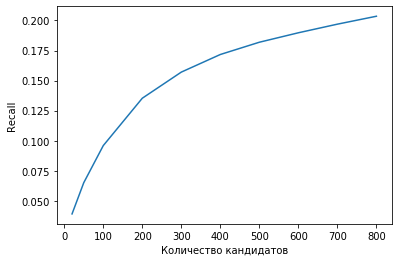

In [22]:
plt.plot(k, recall)
plt.xlabel('Количество кандидатов')
plt.ylabel('Recall')

При росте k растет и recall

##### Задание С)

Число k надо выбирать так, что бы модель второго уровня могла справиться с количество данных. В данном случае, я бы остановил выбор на 400 кандидатах.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [23]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [24]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [25]:
# Разворачиваем списки кандидатов для каждого юзера в столбец
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)

users_lvl_2.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


In [26]:
# Формируем датасет с целевой переменной
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

In [27]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


In [28]:
# Удаляем появившиеся дубликаты
targets_lvl_2 = targets_lvl_2.drop_duplicates(keep='first')

In [29]:
# Добавляем фичи юзеров и товаров
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


Добавим фичи юзеров

In [30]:
# Средний чек
mean_check = data_train_lvl_2.groupby(['user_id', 'basket_id'])['sales_value'].sum().reset_index()
mean_check = mean_check.groupby('user_id')['sales_value'].mean().reset_index()
mean_check.rename(columns={'sales_value': 'mean_check'}, inplace=True)
mean_check.head(3)

,user_id,mean_check
0,1,48.825714
1,2,47.572500
2,4,39.796667


In [31]:
# Кол-во покупок в каждой категории
num_purchases_in_category = data_train_lvl_2.merge(item_features, on='item_id', how='left')
num_purchases_in_category.loc[num_purchases_in_category['department'] == ' ', 'department'] = 'UNKNOWN'
num_purchases_in_category = num_purchases_in_category.groupby(['user_id', 'department'])['quantity'].count().reset_index()
num_purchases_in_category.rename(columns={'quantity': 'num_purchases_in_category'}, inplace=True)
num_purchases_in_category.head(3)

,user_id,department,num_purchases_in_category
0,1,DELI,4
1,1,DRUG GM,13
2,1,GROCERY,93


In [32]:
targets_lvl_2 = targets_lvl_2.merge(mean_check, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(num_purchases_in_category, on=['user_id', 'department'], how='left')

In [33]:
targets_lvl_2.head(10)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,num_purchases_in_category
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,3.0
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,139.0
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,29.0
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,29.0
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,29.0
5,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,8.0
6,2070,1032703,0.0,1087,SEAFOOD-PCKGD,National,SEAFOOD - FROZEN,FRZN BRD STICK/PORTON,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,1.0
7,2070,1138596,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,523670 CTN,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,29.0
8,2070,10198378,0.0,69,GROCERY,Private,DOG FOODS,DRY DOG VALUE (PET PRIDE/KLR/G,50 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,139.0
9,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,8.0


Добавим фичи товаров

In [34]:
# Количество покупок в неделю
num_purchases_in_week = data_train_lvl_2.groupby(['item_id', 'week_no'])['quantity'].sum().reset_index()
num_purchases_in_week = num_purchases_in_week.groupby('item_id')['quantity'].mean().reset_index()
num_purchases_in_week.rename(columns={'quantity': 'num_purchases_in_week'}, inplace=True)
num_purchases_in_week.head(2)

,item_id,num_purchases_in_week
0,28116,1.0
1,28117,1.0


In [35]:
# Цена
price = data_train_lvl_2.groupby('item_id')['sales_value'].sum() / data_train_lvl_1.groupby('item_id')['quantity'].sum()
price = price.groupby('item_id').mean().reset_index()
price.columns = ['item_id', 'price']
price['price'].fillna(0, inplace= True)
price.head(2)

,item_id,price
0,28116,0.0
1,28117,0.0


In [36]:
targets_lvl_2 = targets_lvl_2.merge(num_purchases_in_week, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(price, on='item_id', how='left')

Добавим фичи пары юзер-товар

In [37]:
# (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
mean_price_in_category = data_train_lvl_2.merge(item_features, on='item_id', how='left')
mean_price_in_category.loc[mean_price_in_category['department'] == ' ', 'department'] = 'UNKNOWN'

department_quantity = mean_price_in_category.groupby('department')['quantity'].sum().reset_index()
mean_price_in_category = mean_price_in_category.groupby('department')['sales_value'].sum().reset_index()
mean_price_in_category['mean_price'] = mean_price_in_category['sales_value'] / department_quantity['quantity']
mean_price_in_category.drop(['sales_value'], axis=1, inplace=True)
mean_price_in_category.head(3)

,department,mean_price
0,AUTOMOTIVE,5.390000
1,CHEF SHOPPE,2.632464
2,CNTRL/STORE SUP,1.000000


In [38]:
targets_lvl_2 = targets_lvl_2.merge(mean_price_in_category, on='department', how='left')
targets_lvl_2['dif_price'] = targets_lvl_2['mean_price'] - targets_lvl_2['price']
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,num_purchases_in_category,num_purchases_in_week,price,mean_price,dif_price
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,3.0,1.666667,0.191827,4.211823,4.019996
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,139.0,1.000000,0.207358,1.893912,1.686553
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,29.0,NaN,0.000000,3.097031,3.097031


In [39]:
targets_lvl_2.fillna(0, inplace= True)
targets_lvl_2.head(10)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,num_purchases_in_category,num_purchases_in_week,price,mean_price,dif_price
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,3.0,1.666667,0.191827,4.211823,4.019996
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,139.0,1.000000,0.207358,1.893912,1.686553
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,29.0,0.000000,0.000000,3.097031,3.097031
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,29.0,0.000000,0.000000,3.097031,3.097031
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,29.0,2.200000,1.831042,3.097031,1.265989
5,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,8.0,2.000000,0.240435,2.930810,2.690375
6,2070,1032703,0.0,1087,SEAFOOD-PCKGD,National,SEAFOOD - FROZEN,FRZN BRD STICK/PORTON,10.5 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,1.0,2.000000,0.380260,4.678647,4.298387
7,2070,1138596,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,523670 CTN,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,29.0,0.000000,0.000000,3.097031,3.097031
8,2070,10198378,0.0,69,GROCERY,Private,DOG FOODS,DRY DOG VALUE (PET PRIDE/KLR/G,50 LB,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,139.0,2.166667,0.901875,1.893912,0.992037
9,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,8.0,7.200000,0.465528,2.930810,2.465283


In [40]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [41]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [42]:
# Тренируем модель и предсказываем вероятности
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\Users\Spoukster\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Spoukster\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Spoukster\anaconda3\lib\site-packages\lightgbm\basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [43]:
# Берем вероятность класса 1
proba_1 = [i[1] for i in train_preds]

In [44]:
result = targets_lvl_2[['user_id', 'item_id']]
result['proba'] = proba_1
result.head(2)

C:\Users\Spoukster\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,item_id,proba
0,2070,1105426,0.031727
1,2070,1097350,0.017265


In [45]:
# Упорядочим по юзерам и вероятности
result.sort_values(['user_id', 'proba'], ascending=False, inplace=True)
result = result.groupby('user_id').head(5)
result.head(10)

C:\Users\Spoukster\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,item_id,proba
68403,2500,1086061,0.240730
68420,2500,1013389,0.166475
68406,2500,5572308,0.160776
68405,2500,1065538,0.160622
68423,2500,939681,0.151178
85755,2499,1138858,0.170272
85765,2499,9523059,0.169788
85748,2499,889989,0.161369
85777,2499,9575582,0.148725
85775,2499,867931,0.130817


In [46]:
# Соберем результаты в строку
result = result.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'lgbm_rec']
result.head(3)

,user_id,lgbm_rec
0,1,"[877391, 856942, 1124029, 8293439, 9655212]"
1,2,"[1110244, 862725, 898847, 907099, 9416729]"
2,4,"[908283, 883932, 1079528, 1115098, 955867]"


In [47]:
# Уберем юзеров, которых нет во втором тренировочном наборе
train_users_lvl_2 = result['user_id'].unique()
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2['user_id'].isin(train_users_lvl_2)]
data_val_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0


In [48]:
# Создадим валидационный набор
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [49]:
result_lvl_2 = result_lvl_2.merge(result, on='user_id', how='left')
result_lvl_2.head(2)

,user_id,actual,lgbm_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[877391, 856942, 1124029, 8293439, 9655212]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[900802, 1098844, 12757544, 6979393, 825541]"


Посмотрим на качество рекомендаций 2хуровневой модели по метрике precision@5.

In [50]:
result_lvl_2.apply(lambda row: precision_at_k(row['lgbm_rec'], row['actual'], k=5), axis=1).mean()

0.15874673629242675

Для сравнения посмотрим на precision@5 лучшего метода отбора кандидатов одноуровневой модели own_recommended и ALS

In [51]:
result_lvl_1.apply(lambda row: precision_at_k(row['own_rec'], row['actual'], k=50), axis=1).mean()

0.07215413184772553

In [52]:
result_lvl_1.apply(lambda row: precision_at_k(row['als_rec'], row['actual'], k=50), axis=1).mean()

0.05530176415970292

Видим, что двухуровневая модель показывает лучший результат. Но это без подбора гиперпараметров.

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 